In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import numpy as np
import statsmodels as sm
import pandas as pd
import scipy.stats as stats, scipy.interpolate as interp
from scipy.integrate import quad
from scipy.special import smirnov
from scipy.spatial import distance
import statsmodels.stats.proportion as proportion
from statsmodels import distributions
import warnings, scipy, statistics
from matplotlib.lines import Line2D
import matplotlib.animation as animation
from matplotlib import rc, rcParams
rcParams['font.family'] = "serif"
rc('text', usetex=True)
rcParams.update({'font.size': 70, 'legend.fontsize':20}) #, 'figure.figsize': [10,10], )

In [2]:
with fits.open('L50M_mass_age_all.fits') as hdul:
    L50_all = hdul[1].data
with fits.open('L70M_mass_age_all.fits') as hdul:
    L70_all = hdul[1].data
with fits.open('L100M_mass_age_all.fits') as hdul:
    L100_all = hdul[1].data
with fits.open('Lv_mass_age_all.fits') as hdul:
    Lv_all = hdul[1].data
with fits.open('L50M_mass_age_cluster1.fits') as hdul:
    L50_cluster1 = hdul[1].data
with fits.open('L50M_mass_age_cluster2.fits') as hdul:
    L50_cluster2 = hdul[1].data
with fits.open('L50M_mass_age_cluster3.fits') as hdul:
    L50_cluster3 = hdul[1].data
with fits.open('L50M_mass_age_cluster4.fits') as hdul:
    L50_cluster4 = hdul[1].data
with fits.open('L50M_mass_age_cluster5.fits') as hdul:
    L50_cluster5 = hdul[1].data
with fits.open('L100M_mass_age_cluster1.fits') as hdul:
    L100_cluster1 = hdul[1].data
with fits.open('L100M_mass_age_cluster2.fits') as hdul:
    L100_cluster2 = hdul[1].data
with fits.open('L100M_mass_age_cluster3.fits') as hdul:
    L100_cluster3 = hdul[1].data
with fits.open('L100M_mass_age_cluster4.fits') as hdul:
    L100_cluster4 = hdul[1].data
with fits.open('L100M_mass_age_cluster5.fits') as hdul:
    L100_cluster5 = hdul[1].data
with fits.open('L70M_mass_age_cluster1.fits') as hdul:
    L70_cluster1 = hdul[1].data
with fits.open('L70M_mass_age_cluster2.fits') as hdul:
    L70_cluster2 = hdul[1].data
with fits.open('L70M_mass_age_cluster3.fits') as hdul:
    L70_cluster3 = hdul[1].data
with fits.open('L70M_mass_age_cluster4.fits') as hdul:
    L70_cluster4 = hdul[1].data
with fits.open('L70M_mass_age_cluster5.fits') as hdul:
    L70_cluster5 = hdul[1].data

In [3]:
L50 = Table([[10**x for x in L50_all['mass']], L50_all['age']], names=('Mass', 'Age')).to_pandas()
L70 = Table([[10**x for x in L70_all['mass']], L70_all['age']], names=('Mass', 'Age')).to_pandas()
L100 = Table([[10**x for x in L100_all['mass']], L100_all['age']], names=('Mass', 'Age')).to_pandas()
Lv = Table([[10**x for x in Lv_all['mass']], Lv_all['age']], names=('Mass', 'Age')).to_pandas()

all_masses, all_ages, from_simulation, cluster_num, cluster_masses = [], [], [], [] ,[]


# for sim, name in zip([L50_cluster1, L50_cluster2, L50_cluster3, L50_cluster4, L50_cluster5, L70_cluster1, L70_cluster2, L70_cluster3, L70_cluster4, L70_cluster5, L100_cluster1, L100_cluster2, L100_cluster3, L100_cluster4, L100_cluster5, Lv_all], \
#                      ['L50_cluster1', 'L50_cluster2', 'L50_cluster3', 'L50_cluster4', 'L50_cluster5', 'L70_cluster1', 'L70_cluster2', 'L70_cluster3', 'L70_cluster4', 'L70_cluster5', 'L100_cluster1', 'L100_cluster2', 'L100_cluster3', 'L100_cluster4', 'L100_cluster5', 'Lv_all']):
    
    
# just do the most massive 3 clusters

for sim, name in zip([L50_cluster1, L50_cluster2, L50_cluster3, L70_cluster1, L70_cluster2, L70_cluster3, L100_cluster1, L100_cluster2, L100_cluster3, Lv_all], 
                     ['L50_cluster1', 'L50_cluster2', 'L50_cluster3', 'L70_cluster1', 'L70_cluster2', 'L70_cluster3', 'L100_cluster1', 'L100_cluster2', 'L100_cluster3', 'Lv_cluster1']):
    all_masses += [10**x for x in sim['mass']] # want in units of solar masses for normalize_kroupa()
    
    for n in ["L50", "L70", "L100", "Lv"]:
        if n in name: 
            from_simulation += [n]*len(sim)
            cluster = name.replace("_", " ")
            cluster_num += [cluster]*len(sim)
    cluster_masses.append(sum(sim['mass']))
    
df = pd.DataFrame([x for x in zip(all_masses, from_simulation, cluster_num)], columns=['Mass', 'Simulation', 'Cluster']) 

In [4]:
# PP plot compares quantiles (idealized samples, e.g. groups of 5) where each data point
# in sample is paired w/ similar member from the theoretical cumulative distribution 
# at the same x value. A perfect match will be along the diagonal line, deviations from
# diagonal show deviation from expected distribution. A point indicates what percentage
# of the total mass is at or under that quantile of the distribution

def pp_plot(x, dist_cdf, line=True, ax=None, label=None):
    '''
    Function for comparing empirical data to a theoretical distribution by using a P-P plot.
    
    Params:
    x - empirical data
    dist - distribution object from scipy.stats; for example scipy.stats.norm(0, 1)
    line - boolean; specify if the reference line (y=x) should be drawn on the plot
    ax - specified ax for subplots, None is standalone
    '''
    if ax is None:
        ax = plt.figure().add_subplot(1, 1, 1)
        
    n = len(x)
    p = np.arange(1, n + 1) / n - 0.5 / n
    pp = np.sort(dist_cdf)
    
    if label != None:
            sns.scatterplot(x=p, y=pp, ax=ax, label=label)
            ax.legend(frameon=False, fontsize='small')
    else:
        sns.scatterplot(x=p, y=pp, ax=ax)
    ax.margins(x=0, y=0)
    
    if line: plt.plot(np.linspace(0, 1), np.linspace(0, 1), 'black', linestyle='dashed', lw=2)

    return ax


In [69]:
# Define two parts of IMF
def low_imf(x):
    return x ** (-1.3)
def high_imf(x):
    return 0.5 * x ** (-2.3)
def low_int(x):
    return x ** (-0.3)
def high_int(x):
    return 0.5 * x ** (-1.3)

def normalize_kroupa(cluster_mass):

    # Normalization for Kroupa IMF and total mass
    # Integrate Kroupa distribution and create scale factor C such that 
    # kroupa dist represents same total mass as sample cluster

    norm_kroupa = quad(low_int, 0.08, 0.5)[0] + quad(high_int, 0.5, 150)[0]
    total_mass = cluster_mass
    C = total_mass / norm_kroupa
    
    # Value of KS test highly dependent on number of bins
    bins_imf = np.logspace(np.log10(0.08), np.log10(150), 10001)
    #bins_imf = np.linspace(0.08, 150, 10001)
    #bins, counts = np.unique(masses, return_counts=True)
    x_imf      = []
    imf_imf    = []
    for i in range(len(bins_imf) - 1):
        # integrate Kroupa across bins and scale
        x_imf.append(10 ** ((np.log10(bins_imf[i]) + np.log10(bins_imf[i+1])) / 2))
        imf_imf.append(C * np.min([quad(low_imf, bins_imf[i], bins_imf[i+1])[0], \
                                               quad(high_imf, bins_imf[i], bins_imf[i+1])[0]]))
    print("Comparing cluster total mass to Kroupa total:", cluster_mass, sum(np.array(x_imf)*np.array(imf_imf)))
    return x_imf, imf_imf


from scipy.stats import rv_continuous
class Kroupa(stats.rv_continuous):
    def __init__(self, masses):
        
        self.bins, self.counts = normalize_kroupa(sum(masses))
        self.kde = stats.gaussian_kde(self.bins, weights=self.counts)
        
    def pdf(self, new_x):
#         counts, bin_edges = np.histogram(self.bin_centers, weights=self.counts, density=True)
#         bin_centers = [np.average(bin_edges[i:i+1]) for i,b in enumerate(bins[:-1])]
#         return np.array(bin_centers), counts
        fig, ax = plt.subplots()
        p = pd.DataFrame([x for x in zip(self.bins, self.counts)], columns=['bins', 'counts'])
        sns.kdeplot(data=p, x='bins', weights='counts',  ax=ax, gridsize=10000, cut=0) #color='black')
        line = ax.lines[0]
        bins, pdf = line.get_data()
        pdf_interp = interp.interp1d(bins, pdf)
        pdf_eval = pdf_interp(new_x)
        ax.plot(new_x, pdf_eval)
        
        
#         kde = stats.gaussian_kde(bins, bw_method=0.2 / np.std(self.bins, ddof=1))
#         ax.plot(bins, kde.evaluate(bins), color='red')
        #return kde.evaluate(x_grid)
        #ax.plot(x, pdf_eval, alpha=0.2, color='red')
        
#         def objective(x, a, b, c):
#             return a * x + b
#         # fit curve
#         popt, _ = curve_fit(objective, x, pdf)
        
        plt.show()
        return pdf_eval
    
    def cdf(self, x):
        #cdf = [self.kde.integrate_box_1d(i, i+1) for i,b in enumerate(x[:-1])]
        fig, ax = plt.subplots()
        p = pd.DataFrame([x for x in zip(self.bins, self.counts)], columns=['bins', 'counts'])
        sns.histplot(data=p, x='bins', weights='counts', alpha=0.4, stat='proportion', cumulative=True, element='step', ax=ax, bins=10000, fill=False)
        line = ax.lines[0]
        bins, cdf = line.get_data()
        cdf_interp = interp.interp1d(np.linspace(0, 150, len(cdf)), np.array(cdf))
        cdf_eval = cdf_interp(x)
        plt.close(fig)
        return cdf_eval
    
    def ppf(self, x):
        #ppf1 = interpolate.interp1d(discerete_cdf1, data[0][:-1])
        return 1/self.cdf(x)
    
    def pmf(self, x):
#         val, counts = np.unique(self.kroupa_masses, return_counts=True)
#         self.pmf = counts/len(self.kroupa_masses)
#         df = pd.DataFrame(x)
#         self.pmf = df.value_counts(normalize=True)

        #probs = counts / np.sum(counts)
        
        #self.pmf.index and self.pmf.values
        return self.pmf
    
    def median(self, loc=0, scale=1):
        self.median = scale*np.median(self.x)+loc
        return np.around(self.median, decimals=3)
    
    def mean(self, loc=0, scale=1):
         self.mean = np.average(self.x, weights=self.counts)
#         mean = scale*np.mean(self.x)+loc
         return np.around(self.mean, decimals=3)
    
    def std(self, loc=0, scale=1):
#         std = scale*np.std(self.x)+loc
        self.std = np.average((self.bins - self.mean)**2, weights=self.counts)
        return np.around(self.std, decimals=3)
    
    def skew(self, loc=0, scale=1):
        # for unimodal continuous distributions, skew > 0 means more weight in right tail
        
        #self.skew = skew = 3*(np.average(self.bins)-np.median(self.bins))/np.std(self.bins)
        skew = scale*stats.skew(self.bins)+loc
        return skew
#         return scale*stats.skew(self.x_imf, nan_policy='propogate')+loc
    
    def stats(self, loc=0, scale=1, moments='mv'):
        mean = self.mean()
        var = self.var()
#         skew = self.skew()
#         kurtosis = self.kurtosis()
        
        if moments == 'm': return mean
        elif moments == 'v': return var
        elif moments == 's': return skew
        elif moments == 'k': return kurtosis
        elif moments == 'mv': return mean, var
        elif moments == 'mvs': return mean, var, skew
        elif moments == 'mvsk': return mean, var, skew, kurtosis
        elif moments == 'vs' or 'sv': return var, skew
        elif moments == 'vsk' or 'vks' or 'svk' or 'skv' or 'ksv' or 'kvs': return var, skew, kurtosis
        elif moments == 'sk': return skew, kurtosis 


class Cluster(stats.rv_continuous):
    def __init__(self, masses, limit=None):
        self.x = np.sort(masses)
#         self.color = color
#         self.label = label
        if limit == None: self.limit = max(self.x)
        else: 
            self.x = self.x[self.x <= limit]
            self.limit = limit
        self.kroupa_x, self.kroupa_imf = self.get_kroupa()
    
    def pdf(self, ax={}):
#         try:
#             axis = ax
#         except:
#             fig, axis = plt.subplots(figsize=(8,8))
#             axis.set_title('%s PDF' % self.label)
#         n, bin_edges, barcontainer = axis.hist(self.x, bins=10000, density=True)
#         bins = [np.average(bin_edges[i:i+1]) for i,b in enumerate(bin_edges[:-1])]
#         barcontainer.remove()
#         axis.plot(bins, n, color=self.color, label=self.label)
#         self.pdf_bins, self.pdf = bins, n
#         plt.show()
#         return n, bins
        p = pd.DataFrame([x for x in self.x], columns=['Mass'])
        sns.kdeplot(data=p, x='Mass',  ax=axis, gridsize=10000, cut=0) #color='black')
        line = axis.lines[-1]
        bins, pdf = line.get_data()
        self.pdf = pdf
        plt.show()
        return bins, pdf
        
    def cdf(self, ax={}):
#         try:
#             axis = ax
#         except:
#             fig, axis = plt.subplots(figsize=(8,8))
#             axis.set_title('%s CDF' % self.label)
            
#         n, bin_edges, barcontainer = axis.hist(self.x, bins=10000, density=True, cumulative=True)
#         bins = [np.average(bin_edges[i:i+1]) for i,b in enumerate(bin_edges[:-1])]
#         barcontainer.remove()
#         axis.plot(bins, n, color=self.color, label=self.label)
#         self.cdf_bins, self.cdf = bins, n
#         plt.show()
#         return n, bins
        p = pd.DataFrame([x for x in self.x], columns=['Mass'])
        sns.histplot(data=p, x='Mass', alpha=0.4, stat='density', cumulative=True, element='step', ax=axis, bins=len(self.x), color=self.color, fill=False)
        line = axis.lines[-1]
        x, cdf = line.get_data()
        plt.close()
        self.cdf = cdf
        return x, cdf

    def get_kroupa(self):
        self.kroupa = Kroupa(self.x)
        x_imf, imf_imf = self.kroupa.bins, self.kroupa.counts  #normalize_kroupa(sum(self.x))
        idx = np.where(np.array(x_imf) <= self.limit)[0]
        x = np.array(x_imf)[idx]
        imf = np.array(imf_imf)[idx]
        
        return x, imf
        
    def kroupa_cdf(self, ax={}):
        x, imf = self.get_kroupa()
        
#         try:
#             axis = ax
#         except:
#             fig, axis = plt.subplots(figsize=(8,8))
#             axis.set_title('Kroupa CDF')
        
        p = pd.DataFrame([x for x in zip(x, imf)], columns=['bins', 'counts'])
        sns.histplot(data=p, x='bins', weights='counts', alpha=0.4, stat='proportion', cumulative=True, element='step', ax=axis, bins=len(self.x), color='black', fill=False)
        line = axis.lines[-1]
        x, cdf = line.get_data()
        plt.show()
        self.kcdf = cdf
        return x, cdf
    
#         n, bin_edges, barcontainer = axis.hist(x, weights=imf, bins=10000, density=True, cumulative=True)
#         bins = [np.average(bin_edges[i:i+1]) for i,b in enumerate(bin_edges[:-1])]
#         barcontainer.remove()
#         axis.plot(n, bins, label='Kroupa', color='black')
#         self.kcdf_bins, self.kcdf = bins, n


        
    def kroupa_pdf(self, ax={}):
        x, imf = self.get_kroupa()
        
#         try:
#             axis = ax
#             ax.plot([], [])
#         except:
#             fig, axis = plt.subplots(figsize=(8,8))
#             axis.set_title('Kroupa PDF')
#         n, bin_edges, barcontainer = axis.hist(x, weights=imf, bins=10000, density=True)
#         bins = [np.average(bin_edges[i:i+1]) for i,b in enumerate(bin_edges[:-1])]
#         barcontainer.remove()
#         axis.plot(bins, n, label='Kroupa', color='black')
#         self.kpdf_bins, self.kpdf = bins, n
#         plt.show()
#         return n, bins
        p = pd.DataFrame([x for x in zip(x, imf)], columns=['bins', 'counts'])
        sns.kdeplot(data=p, x='bins', weights='counts',  ax=axis, gridsize=len(self.x), cut=0, color='black')
        line = axis.lines[-1]
        x, pdf = line.get_data()
        plt.show()
        self.kpdf = pdf
        return x, pdf
        
    def qq_plot(self, q, ax={}):
        # q is an array of quantiles/percentages to compare CDFs at
        
        try:
            axis = ax
        except:
            fig, axis = plt.subplots(figsize=(8,8))
            axis.set_title('%s Q-Q plot' % self.label)
            
        # make 2 CDFs the same length
#         cdf_array = np.array(self.cdf) 
#         kroup_array = np.array(self.kcdf)
        
#         cdf_interp = interp.interp1d(self.cdf_bins, cdf_array)
#         stretch_bins = np.linspace(min(self.cdf_bins), max(self.cdf_bins), kroup_array.size)
#         cdf_stretch = cdf_interp(stretch_bins)
#         axis.scatter(self.kcdf, cdf_stretch, alpha=0.2)
#         axis.plot([0, 1.0], [0, 1.0], color='black', linestyle='--') 
        #print("Comparing lengths of CDF and kroupa CDF:", len(self.cdf), len(self.kcdf))
        k_percentiles = np.percentile(self.kcdf, q)
        #c_percentiles = np.percentile(cdf_stretch, q)
        c_percentiles = np.percentile(self.cdf, q)
        percentiles = np.array([str(x)+"%" for x in q])
        print("Comparing quantiles of CDFs:\n         Simulated      Kroupa\n", np.column_stack((percentiles, c_percentiles, k_percentiles)))
        axis.scatter(k_percentiles, c_percentiles, color='black')
        plt.show()
        return c_percentiles, k_percentiles
        
    def skew(self, loc=0, scale=1):
        # for unimodal continuous distributions, skew > 0 means more weight in right tail
        
        #skew = 3*(np.average(self.bins)-np.median(self.bins))/np.std(self.bins)
        return scale*stats.skew(self.bins)+loc
        return skew
#         return scale*stats.skew(self.x_imf, nan_policy='propogate')+loc
    
    def kurtosis(self, loc=0, scale=1):
        # distribution with a higher kurtosis has a heavier tail
        # kurtosis of normal distribution is zero
        #self.kurt = 1./(np.sqrt(2.*np.pi)) * np.exp( -.5*(self.bins)**2)
        return scale*stats.kurtosis(self.bins)+loc
    
class CDF_container():
    def __init__():
        self.labels = []
        self.cdfs = []
    
    def update(cdf, label):
        if isinstance(cdf, list):
            for x,y in zip(cdf, label):
                self.labels.append(y)
                self.cdfs.append(x)
        else:
            self.labels.append(label)
            self.cdfs.append(cdf)
            

# comparing each simulated cluster to Kroupa

In [58]:
# make sure to change/run this cell if you want to change whether scales are log or not for the plots made by cell below
log_cdf_x = True
log_cdf_y = True
log_pdf_y = True


####################################################

 Doing statistics for stars less than 5 solar masses

*************************************************************

           L50 cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 454.0462313283191 454.0462467721065

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.027' '0.034']
 ['10%' '0.77' '0.811']
 ['20%' '0.899' '0.922']
 ['30%' '0.94' '0.957']
 ['40%' '0.963' '0.973']
 ['50%' '0.977' '0.983']
 ['60%' '0.985' '0.989']
 ['70%' '0.992' '0.993']
 ['80%' '0.996' '0.996']
 ['90%' '0.998' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------

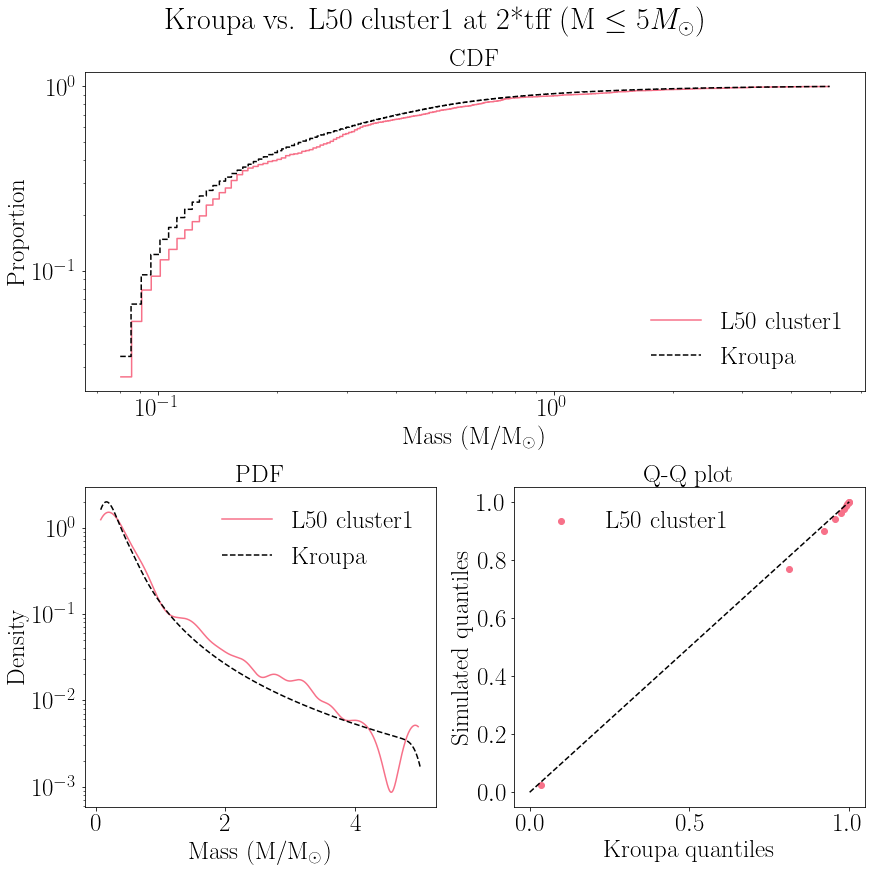


*************************************************************

           L50 cluster2 STATISTICS 

Comparing cluster total mass to Kroupa total: 153.11717443201388 153.11717964009372

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.073' '0.085']
 ['10%' '0.803' '0.815']
 ['20%' '0.919' '0.923']
 ['30%' '0.949' '0.957']
 ['40%' '0.975' '0.974']
 ['50%' '0.98' '0.983']
 ['60%' '0.986' '0.989']
 ['70%' '0.992' '0.993']
 ['80%' '0.992' '0.996']
 ['90%' '0.992' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --  

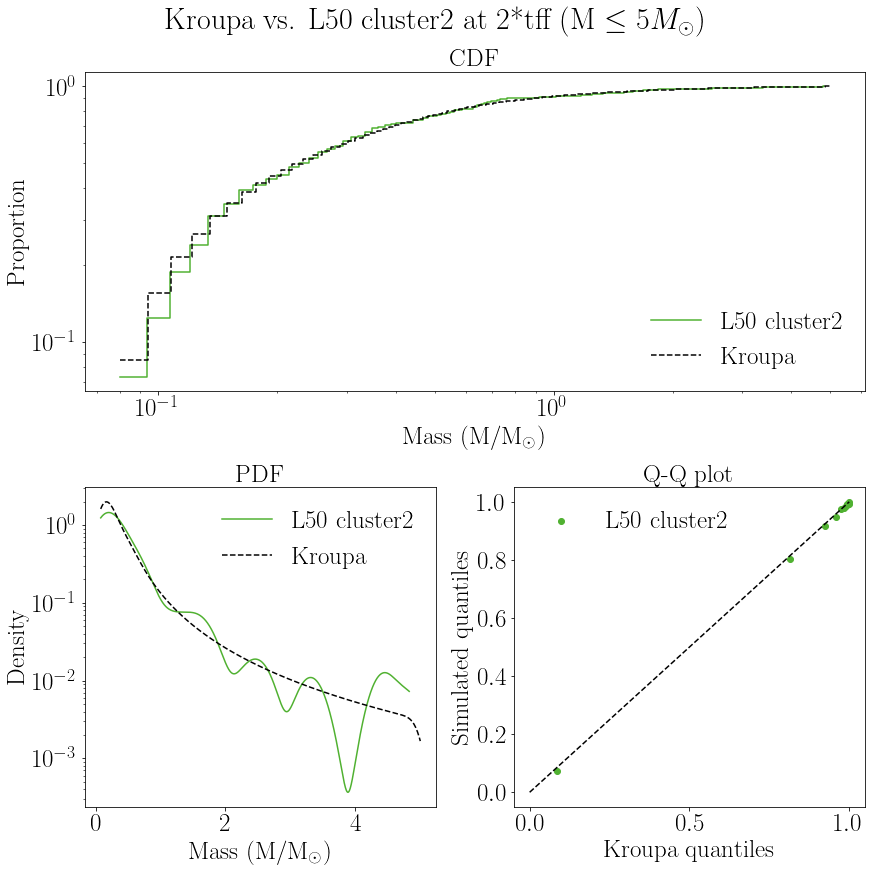


*************************************************************

           L50 cluster3 STATISTICS 

Comparing cluster total mass to Kroupa total: 183.3961176022616 183.39612384024022

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.067' '0.076']
 ['10%' '0.76' '0.814']
 ['20%' '0.888' '0.923']
 ['30%' '0.95' '0.957']
 ['40%' '0.973' '0.974']
 ['50%' '0.983' '0.983']
 ['60%' '0.985' '0.989']
 ['70%' '0.988' '0.993']
 ['80%' '0.99' '0.996']
 ['90%' '0.993' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.379   --    -

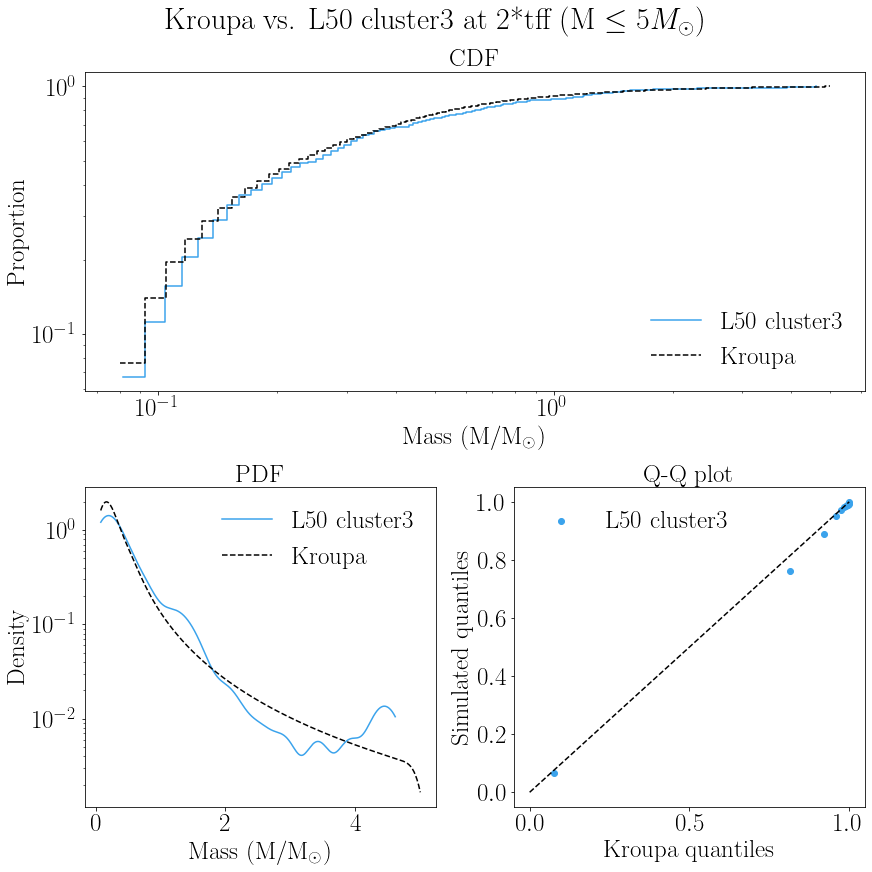


*************************************************************

           L70 cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 261.7744095099385 261.77441841385144

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.031' '0.054']
 ['10%' '0.753' '0.812']
 ['20%' '0.909' '0.922']
 ['30%' '0.947' '0.957']
 ['40%' '0.968' '0.974']
 ['50%' '0.979' '0.983']
 ['60%' '0.983' '0.989']
 ['70%' '0.985' '0.993']
 ['80%' '0.993' '0.996']
 ['90%' '0.995' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --  

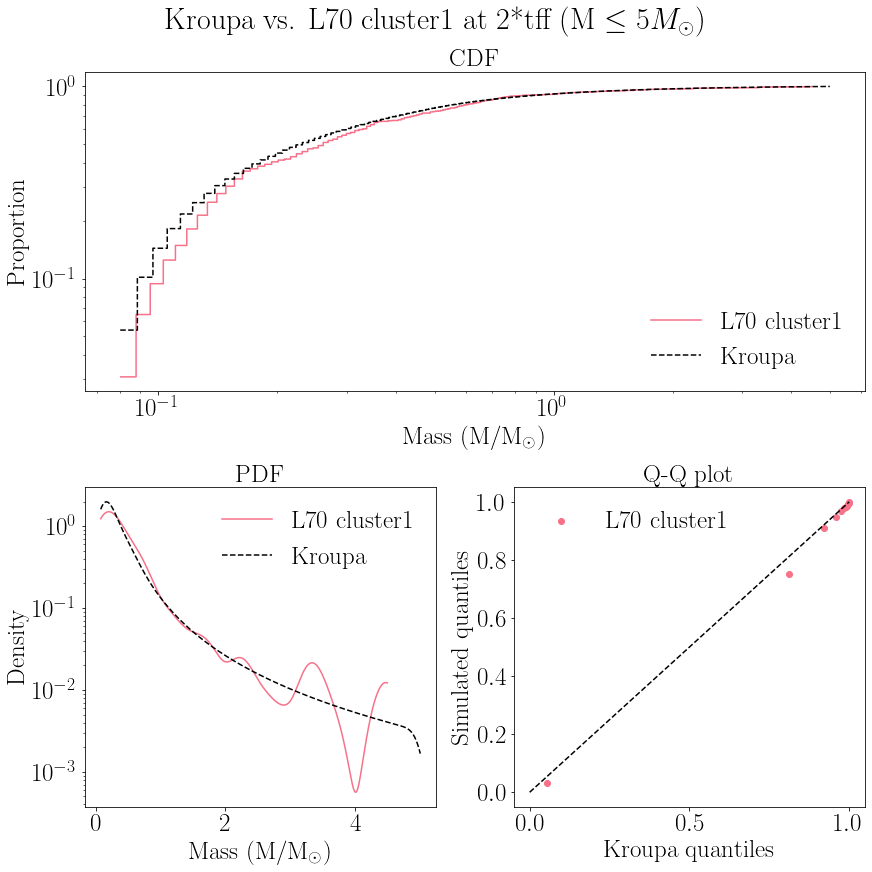


*************************************************************

           L70 cluster2 STATISTICS 

Comparing cluster total mass to Kroupa total: 189.49379779172602 189.49380423710895

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.041' '0.07']
 ['10%' '0.761' '0.814']
 ['20%' '0.925' '0.923']
 ['30%' '0.961' '0.957']
 ['40%' '0.98' '0.974']
 ['50%' '0.986' '0.983']
 ['60%' '0.991' '0.989']
 ['70%' '0.991' '0.993']
 ['80%' '0.993' '0.996']
 ['90%' '0.995' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.379   --   

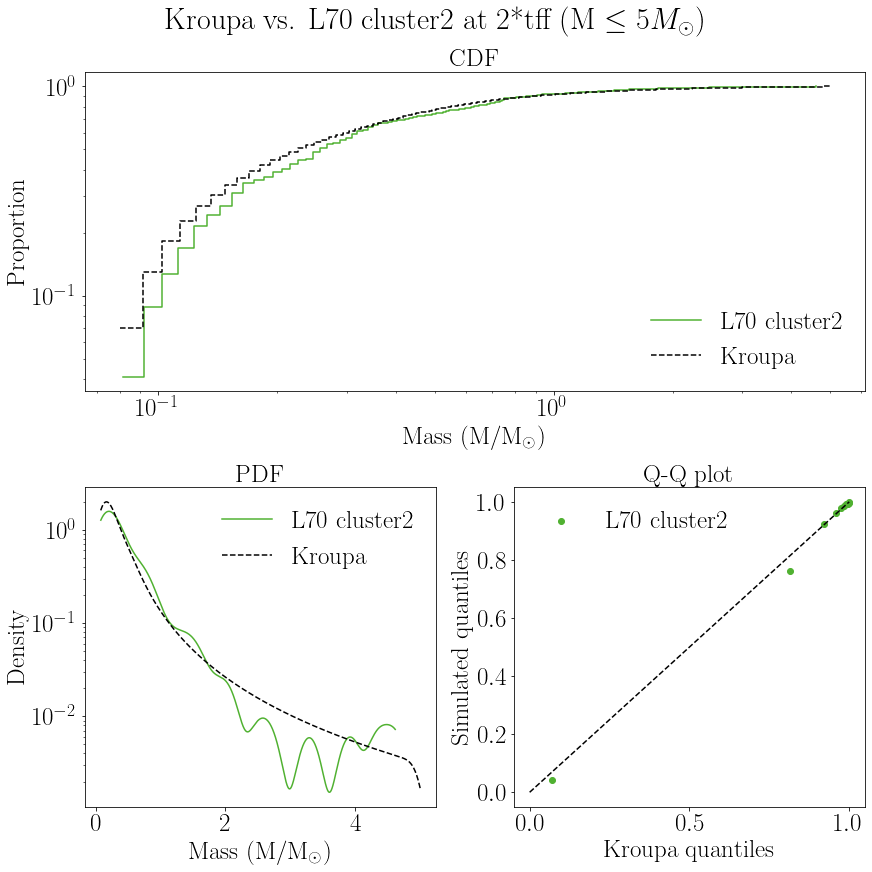


*************************************************************

           L70 cluster3 STATISTICS 

Comparing cluster total mass to Kroupa total: 109.51409398249197 109.51409770747024

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.066' '0.114']
 ['10%' '0.734' '0.817']
 ['20%' '0.888' '0.923']
 ['30%' '0.934' '0.958']
 ['40%' '0.951' '0.974']
 ['50%' '0.965' '0.983']
 ['60%' '0.973' '0.989']
 ['70%' '0.984' '0.993']
 ['80%' '0.988' '0.996']
 ['90%' '0.996' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.378   -- 

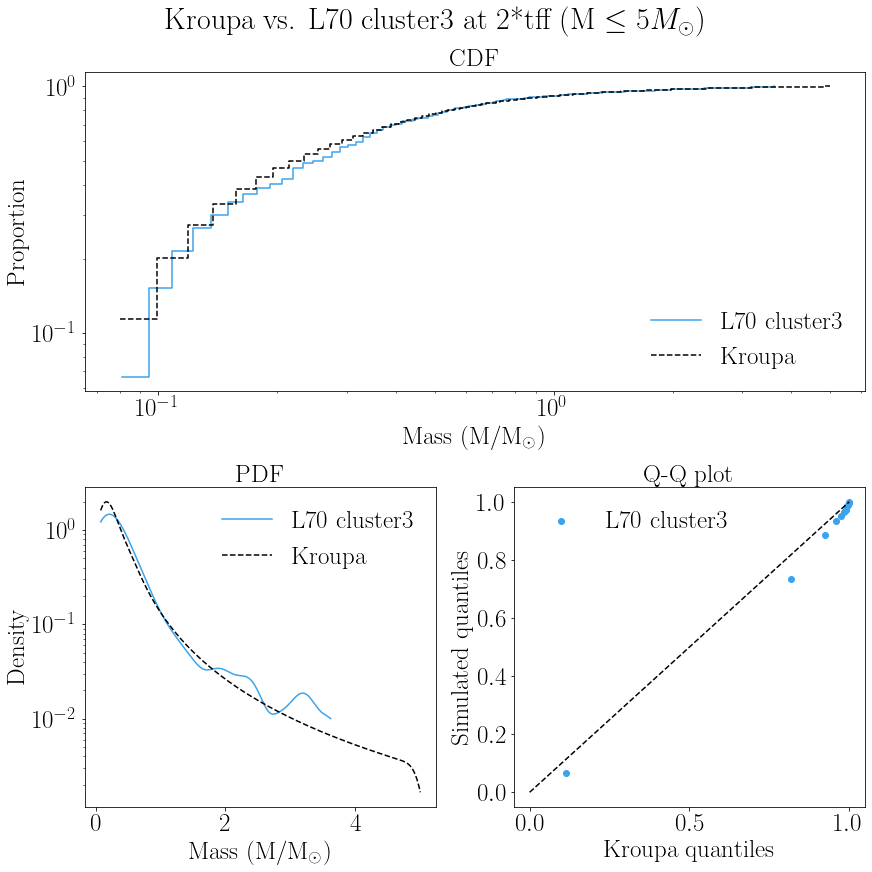


*************************************************************

           L100 cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 293.8633240474987 293.86333404287603

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.034' '0.049']
 ['10%' '0.702' '0.812']
 ['20%' '0.881' '0.922']
 ['30%' '0.917' '0.957']
 ['40%' '0.942' '0.974']
 ['50%' '0.96' '0.983']
 ['60%' '0.966' '0.989']
 ['70%' '0.979' '0.993']
 ['80%' '0.988' '0.996']
 ['90%' '0.991' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --  

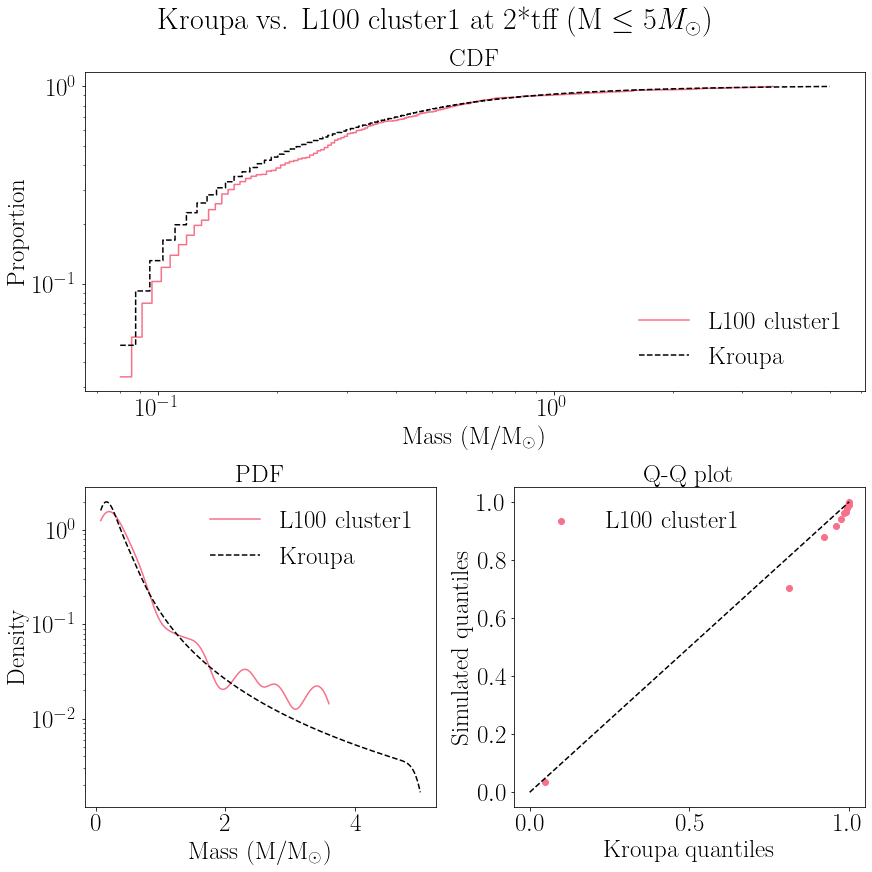


*************************************************************

           L100 cluster2 STATISTICS 

Comparing cluster total mass to Kroupa total: 163.68687302729595 163.68687859489012

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.054' '0.082']
 ['10%' '0.796' '0.814']
 ['20%' '0.909' '0.923']
 ['30%' '0.954' '0.957']
 ['40%' '0.971' '0.974']
 ['50%' '0.987' '0.983']
 ['60%' '0.995' '0.989']
 ['70%' '0.995' '0.993']
 ['80%' '0.995' '0.996']
 ['90%' '0.995' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.378   --

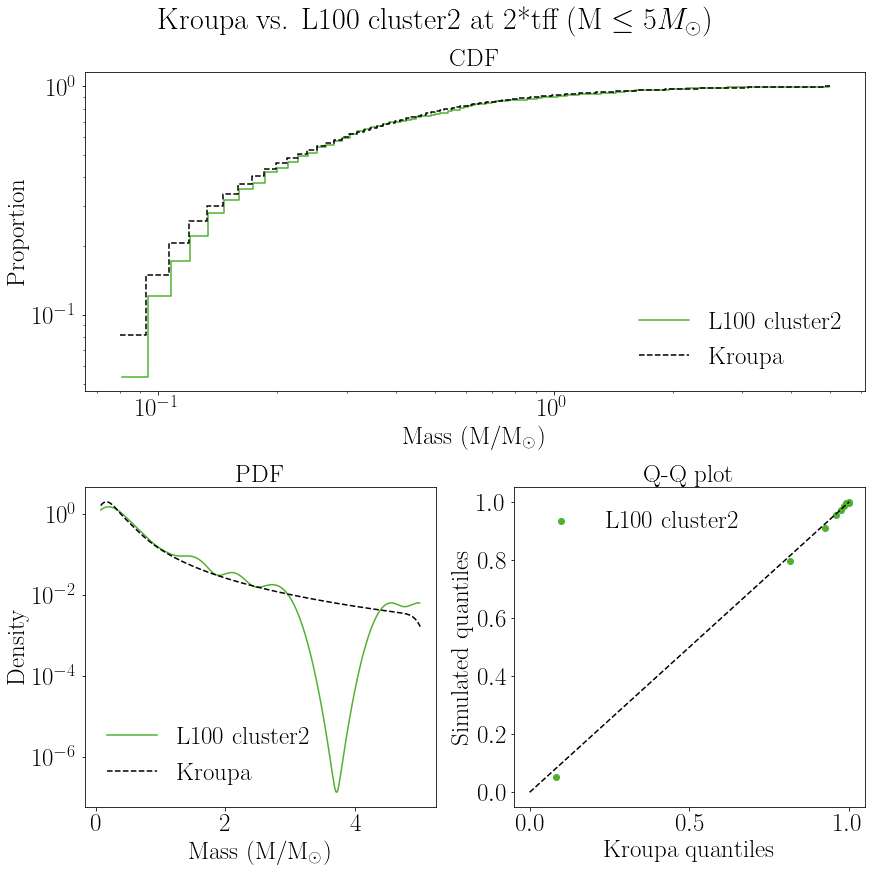


*************************************************************

           L100 cluster3 STATISTICS 

Comparing cluster total mass to Kroupa total: 49.25379310542814 49.25379478073127

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.142' '0.195']
 ['10%' '0.77' '0.824']
 ['20%' '0.916' '0.925']
 ['30%' '0.948' '0.958']
 ['40%' '0.967' '0.974']
 ['50%' '0.978' '0.983']
 ['60%' '0.993' '0.989']
 ['70%' '0.993' '0.993']
 ['80%' '0.993' '0.996']
 ['90%' '0.993' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.380   --   

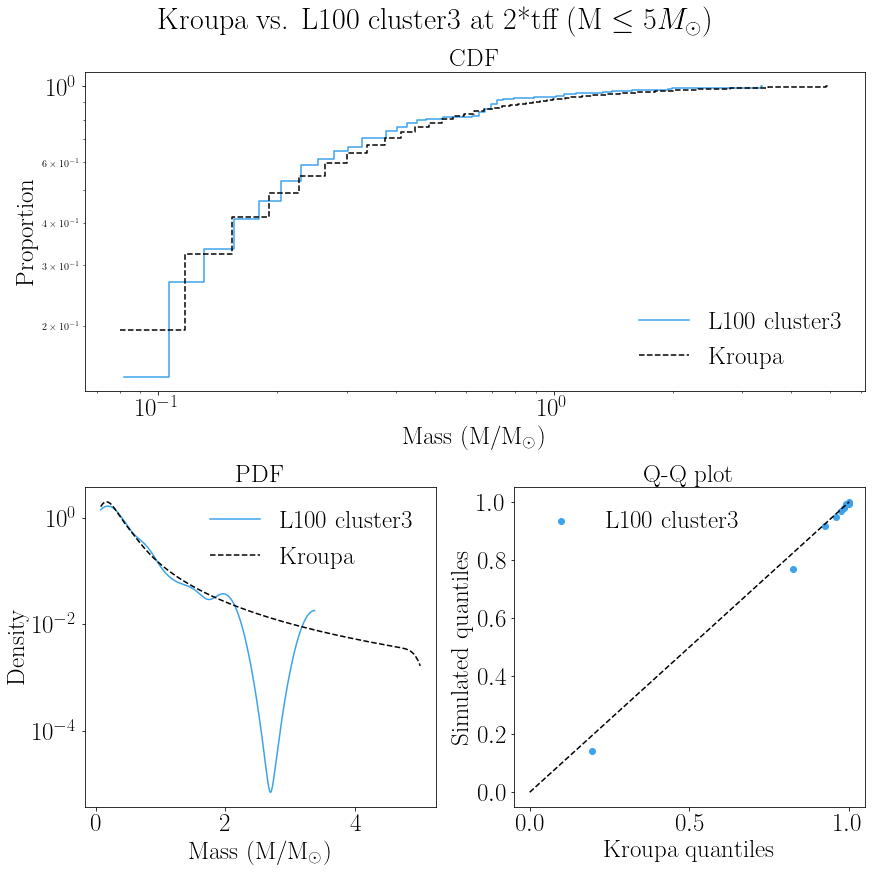


*************************************************************

           Lv cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 2713.0908977768577 2713.0909900590877

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.0' '0.006']
 ['10%' '0.758' '0.809']
 ['20%' '0.907' '0.921']
 ['30%' '0.954' '0.957']
 ['40%' '0.974' '0.973']
 ['50%' '0.981' '0.983']
 ['60%' '0.988' '0.989']
 ['70%' '0.993' '0.993']
 ['80%' '0.995' '0.996']
 ['90%' '0.998' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --    

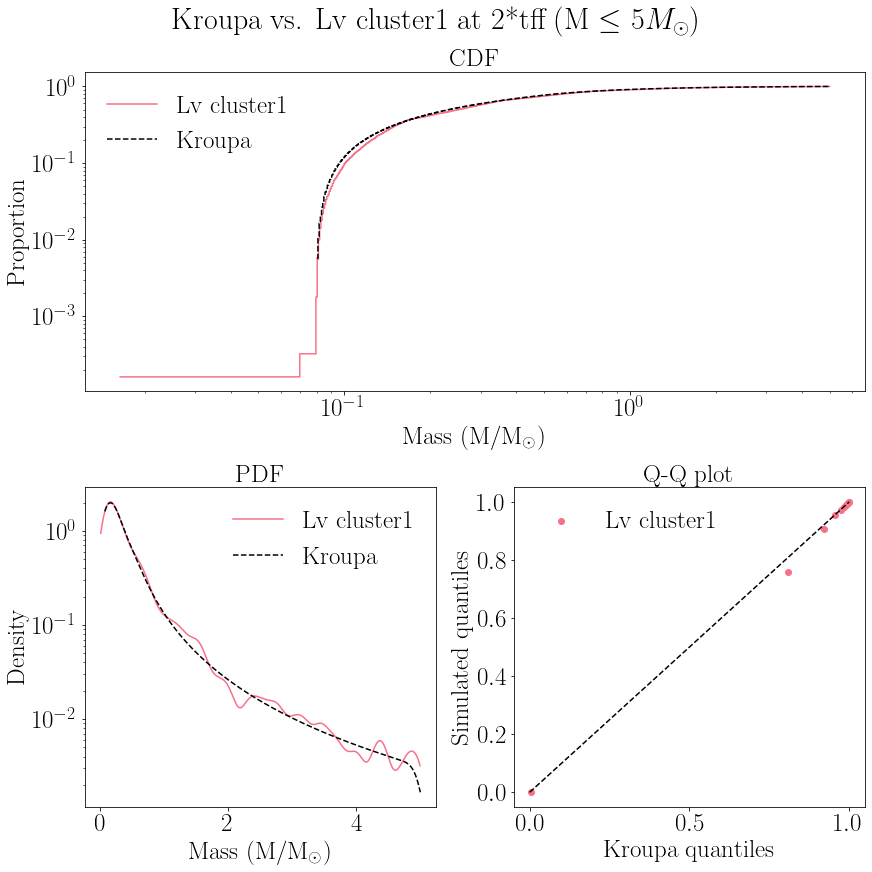


####################################################

 Doing statistics for stars less than 8 solar masses

*************************************************************

           L50 cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 513.7815351154497 513.7815525910543

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.04' '0.053']
 ['10%' '0.848' '0.891']
 ['20%' '0.921' '0.956']
 ['30%' '0.955' '0.976']
 ['40%' '0.972' '0.985']
 ['50%' '0.981' '0.991']
 ['60%' '0.986' '0.994']
 ['70%' '0.987' '0.996']
 ['80%' '0.992' '0.998']
 ['90%' '0.996' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ --------------

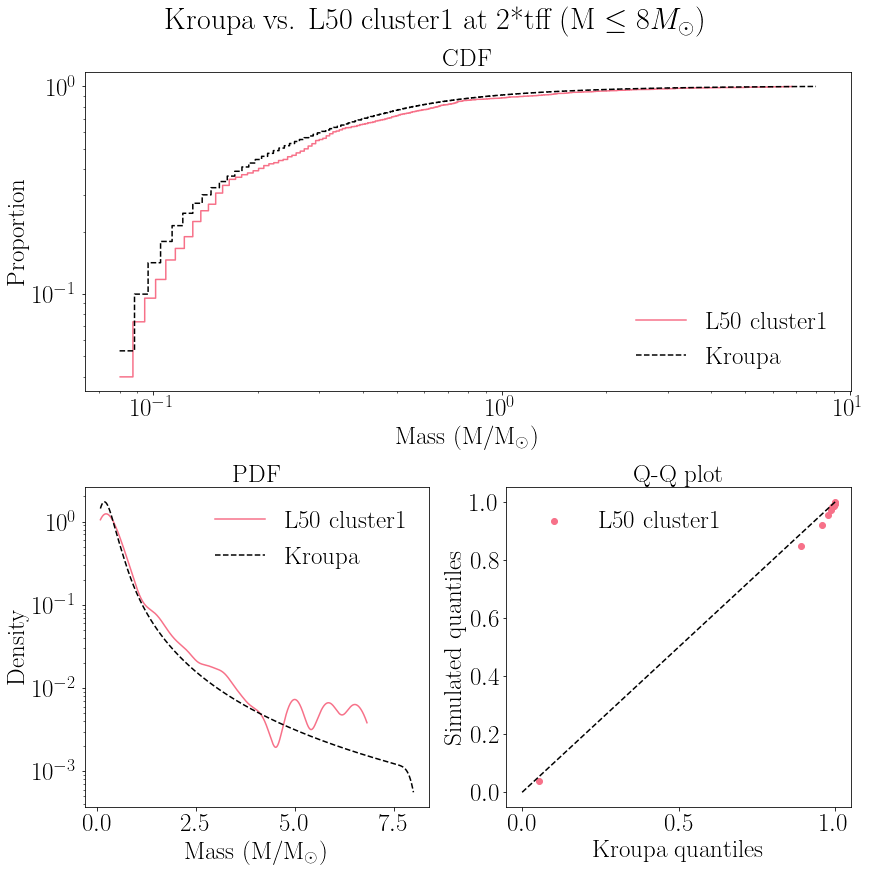


*************************************************************

           L50 cluster2 STATISTICS 

Comparing cluster total mass to Kroupa total: 187.30699003503395 187.30699640603663

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.108' '0.127']
 ['10%' '0.889' '0.893']
 ['20%' '0.947' '0.957']
 ['30%' '0.967' '0.976']
 ['40%' '0.972' '0.986']
 ['50%' '0.978' '0.991']
 ['60%' '0.983' '0.994']
 ['70%' '0.986' '0.996']
 ['80%' '0.989' '0.998']
 ['90%' '0.992' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   -- 

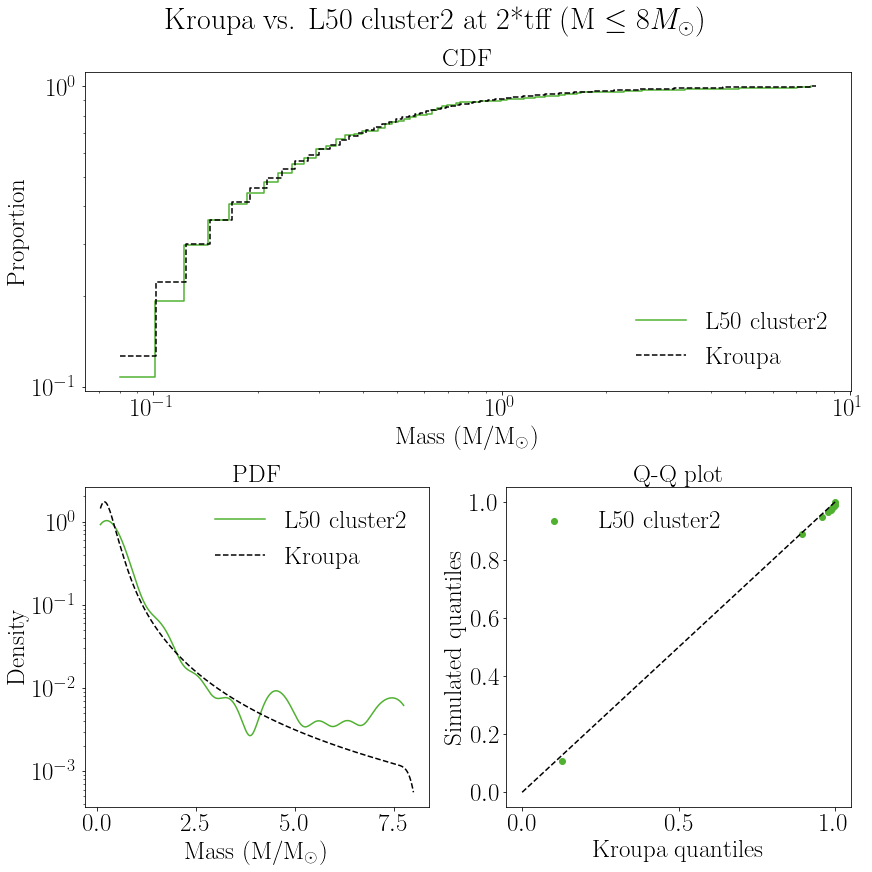


*************************************************************

           L50 cluster3 STATISTICS 

Comparing cluster total mass to Kroupa total: 224.3755328282293 224.3755404600701

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.095' '0.114']
 ['10%' '0.848' '0.893']
 ['20%' '0.946' '0.957']
 ['30%' '0.963' '0.976']
 ['40%' '0.971' '0.986']
 ['50%' '0.973' '0.991']
 ['60%' '0.98' '0.994']
 ['70%' '0.983' '0.996']
 ['80%' '0.995' '0.998']
 ['90%' '0.998' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.379   --    

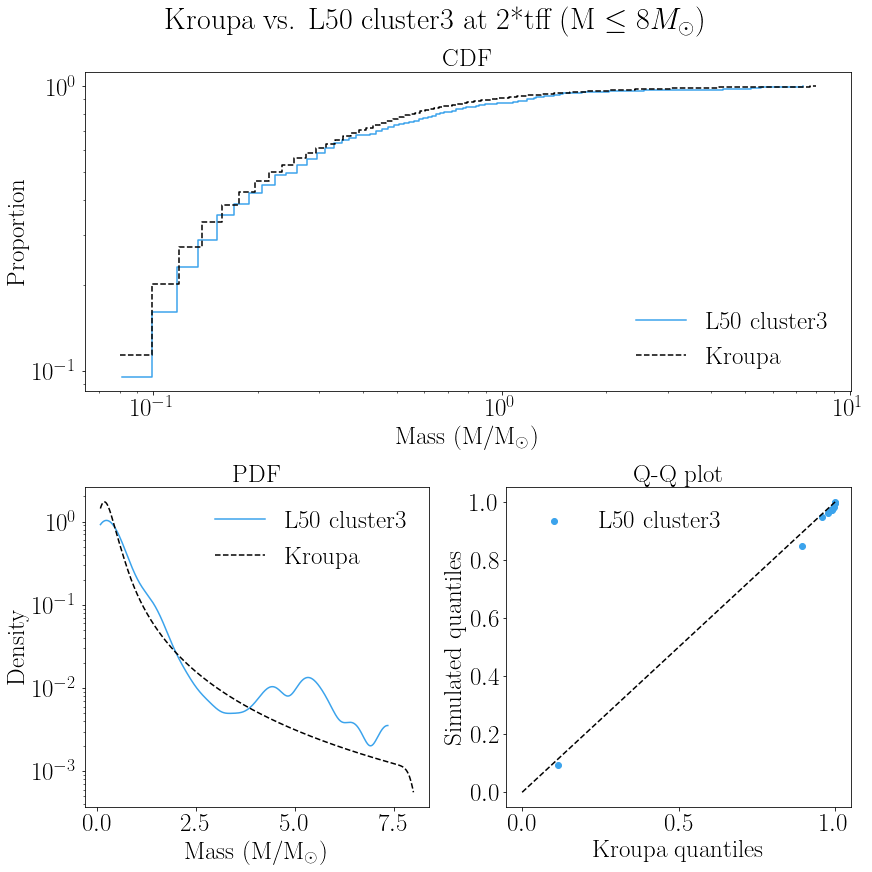


*************************************************************

           L70 cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 276.06591810949965 276.06592749952006

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.056' '0.083']
 ['10%' '0.898' '0.892']
 ['20%' '0.956' '0.957']
 ['30%' '0.976' '0.976']
 ['40%' '0.981' '0.986']
 ['50%' '0.991' '0.991']
 ['60%' '0.997' '0.994']
 ['70%' '0.997' '0.996']
 ['80%' '0.997' '0.998']
 ['90%' '0.998' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   -- 

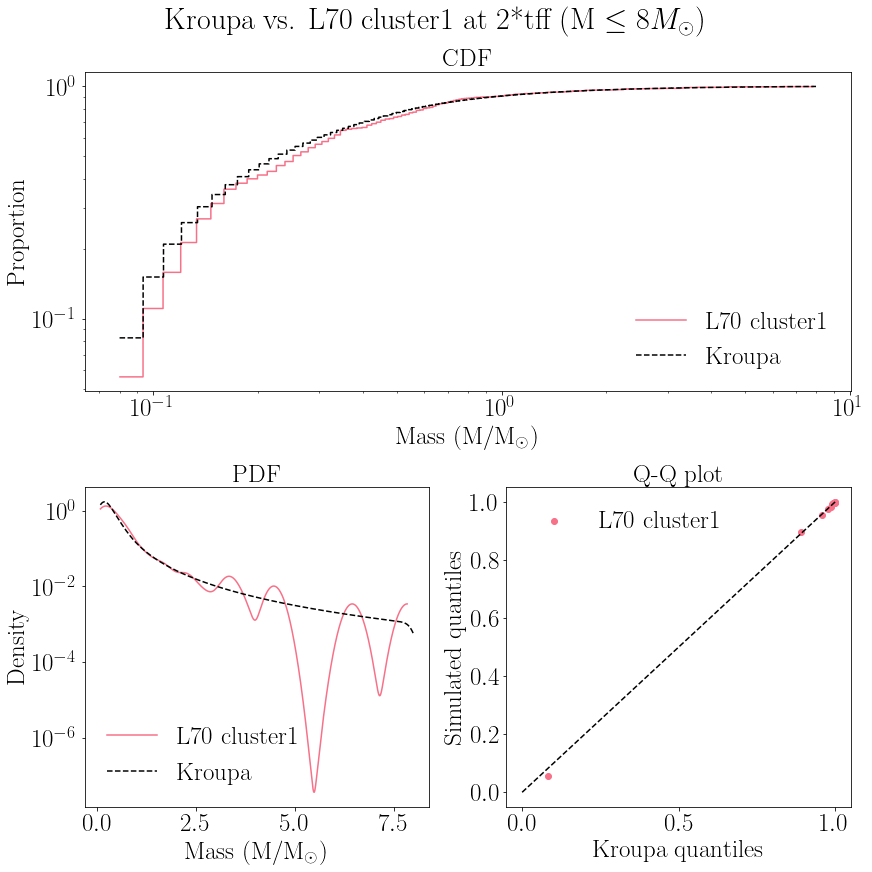


*************************************************************

           L70 cluster2 STATISTICS 

Comparing cluster total mass to Kroupa total: 200.89208575340314 200.8920925864841

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.057' '0.107']
 ['10%' '0.811' '0.893']
 ['20%' '0.937' '0.957']
 ['30%' '0.973' '0.976']
 ['40%' '0.982' '0.986']
 ['50%' '0.986' '0.991']
 ['60%' '0.989' '0.994']
 ['70%' '0.991' '0.996']
 ['80%' '0.995' '0.998']
 ['90%' '0.995' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.379   --  

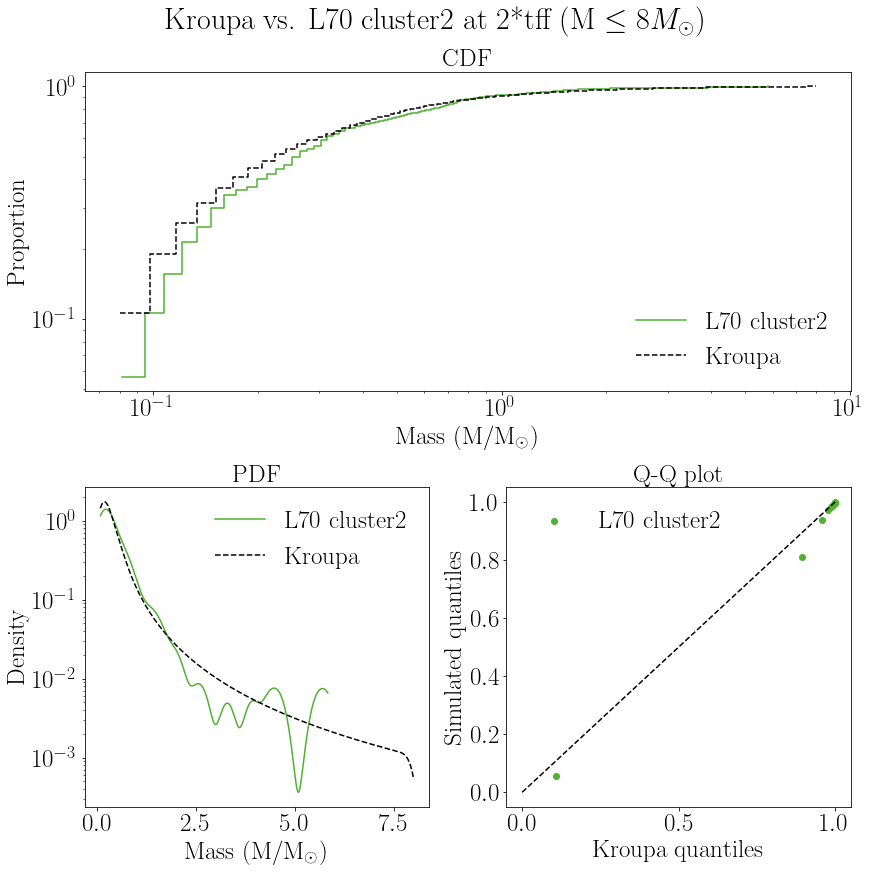


*************************************************************

           L70 cluster3 STATISTICS 

Comparing cluster total mass to Kroupa total: 115.27488050486937 115.2748844257932

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.113' '0.169']
 ['10%' '0.849' '0.895']
 ['20%' '0.935' '0.957']
 ['30%' '0.958' '0.977']
 ['40%' '0.973' '0.986']
 ['50%' '0.984' '0.991']
 ['60%' '0.992' '0.994']
 ['70%' '0.996' '0.996']
 ['80%' '0.996' '0.998']
 ['90%' '0.996' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.378   --  

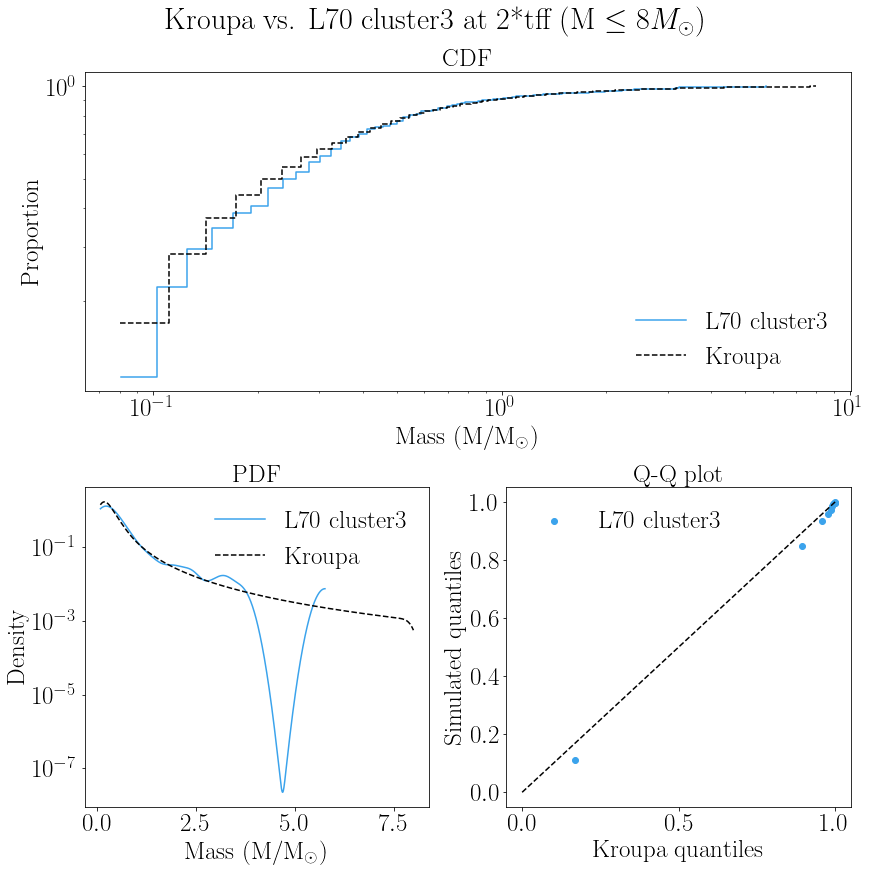


*************************************************************

           L100 cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 318.25013134356243 318.25014216842493

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.05' '0.075']
 ['10%' '0.874' '0.892']
 ['20%' '0.935' '0.957']
 ['30%' '0.96' '0.976']
 ['40%' '0.98' '0.985']
 ['50%' '0.992' '0.991']
 ['60%' '0.994' '0.994']
 ['70%' '0.994' '0.996']
 ['80%' '0.995' '0.998']
 ['90%' '0.997' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --   

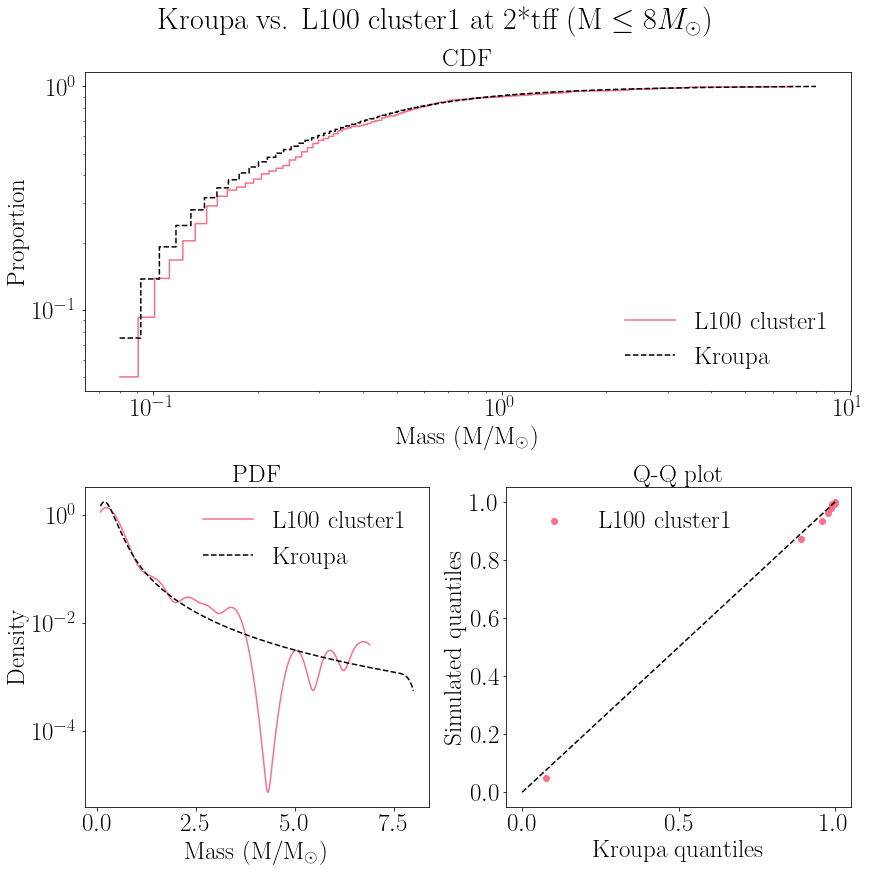


*************************************************************

           L100 cluster2 STATISTICS 

Comparing cluster total mass to Kroupa total: 175.0910153184568 175.09102127394746

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.069' '0.123']
 ['10%' '0.856' '0.893']
 ['20%' '0.928' '0.957']
 ['30%' '0.965' '0.976']
 ['40%' '0.981' '0.986']
 ['50%' '0.989' '0.991']
 ['60%' '0.989' '0.994']
 ['70%' '0.989' '0.996']
 ['80%' '0.997' '0.998']
 ['90%' '0.997' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.378   -- 

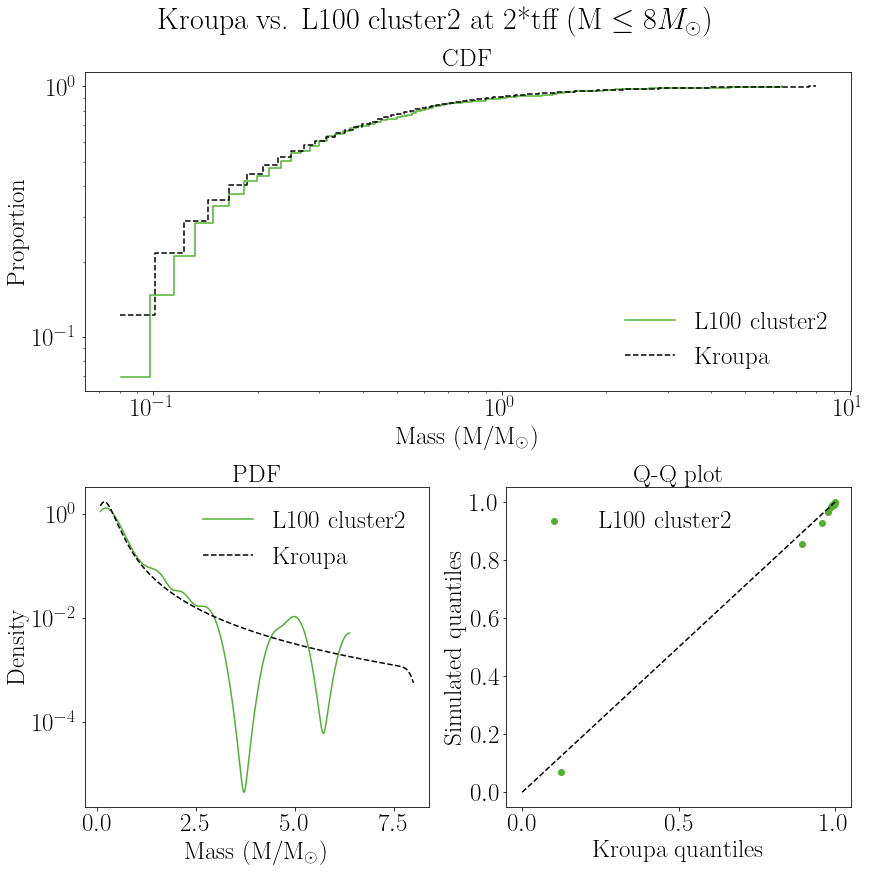


*************************************************************

           L100 cluster3 STATISTICS 

Comparing cluster total mass to Kroupa total: 54.55978900257147 54.55979085835142

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.185' '0.275']
 ['10%' '0.819' '0.899']
 ['20%' '0.948' '0.958']
 ['30%' '0.97' '0.977']
 ['40%' '0.985' '0.986']
 ['50%' '0.985' '0.991']
 ['60%' '0.985' '0.994']
 ['70%' '0.993' '0.996']
 ['80%' '0.993' '0.998']
 ['90%' '0.993' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.380   --   

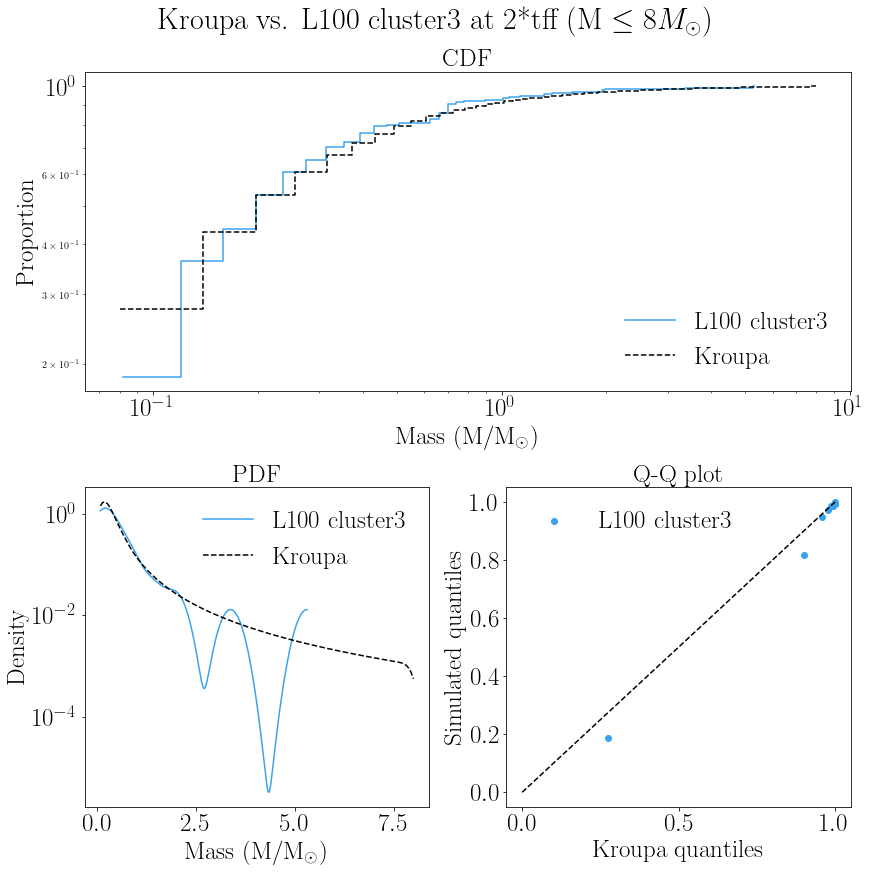


*************************************************************

           Lv cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 2958.8226092404384 2958.822709880926

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.0' '0.009']
 ['10%' '0.874' '0.89']
 ['20%' '0.956' '0.956']
 ['30%' '0.973' '0.976']
 ['40%' '0.984' '0.985']
 ['50%' '0.989' '0.991']
 ['60%' '0.993' '0.994']
 ['70%' '0.995' '0.996']
 ['80%' '0.997' '0.998']
 ['90%' '0.999' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --    --

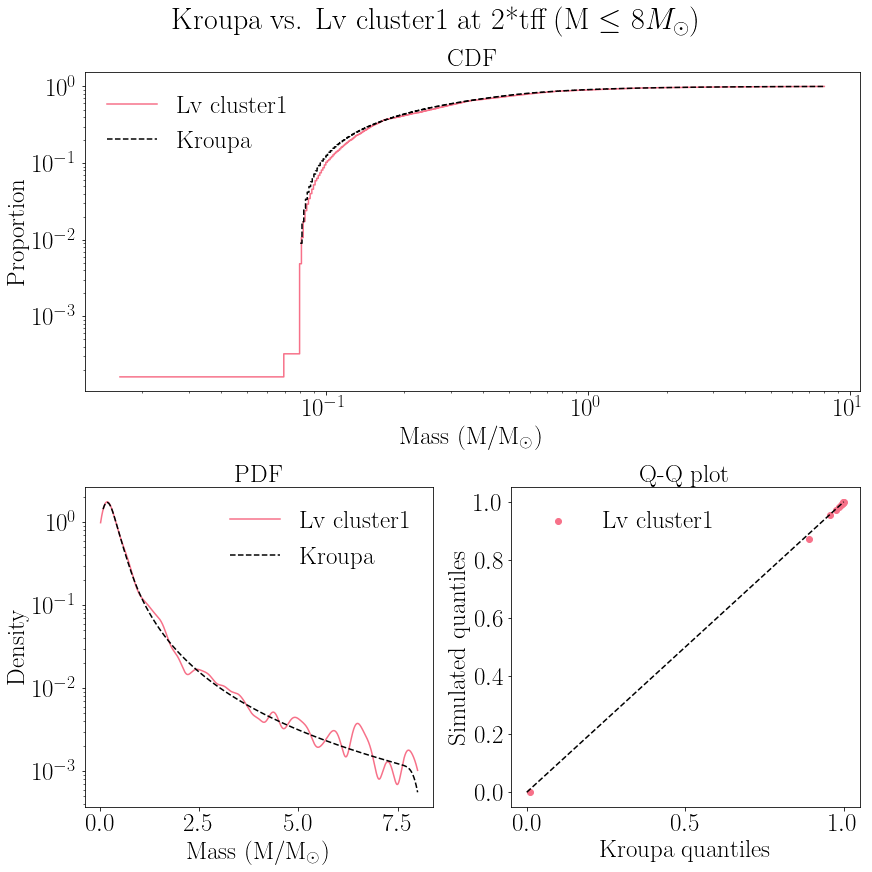


####################################################

 Doing statistics for ALL stars

*************************************************************

           L50 cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 547.7377062223139 547.7377248528927

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.072' '0.084']
 ['10%' '0.916' '0.941']
 ['20%' '0.967' '0.977']
 ['30%' '0.983' '0.988']
 ['40%' '0.988' '0.992']
 ['50%' '0.996' '0.995']
 ['60%' '0.997' '0.997']
 ['70%' '0.997' '0.998']
 ['80%' '0.998' '0.999']
 ['90%' '0.999' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- -

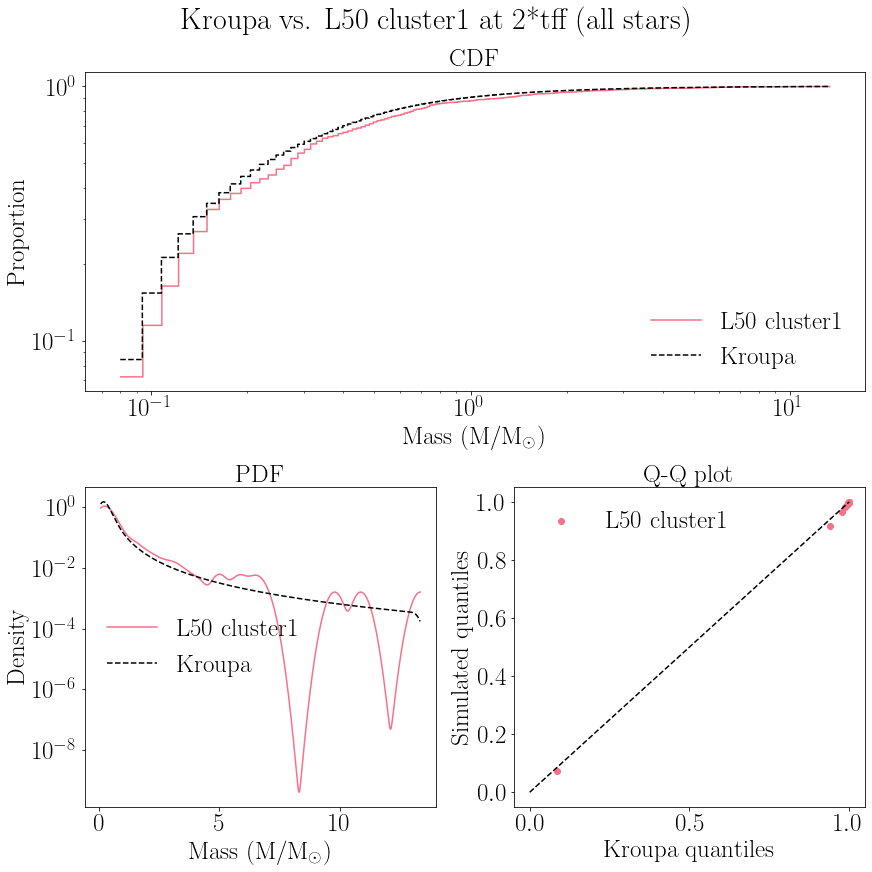


*************************************************************

           L50 cluster2 STATISTICS 

Comparing cluster total mass to Kroupa total: 274.04857946438307 274.0485887857859

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.43' '0.437']
 ['10%' '0.973' '0.988']
 ['20%' '0.989' '0.995']
 ['30%' '0.995' '0.997']
 ['40%' '0.995' '0.998']
 ['50%' '0.996' '0.999']
 ['60%' '0.997' '0.999']
 ['70%' '0.997' '1.0']
 ['80%' '0.997' '1.0']
 ['90%' '0.997' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --    --   

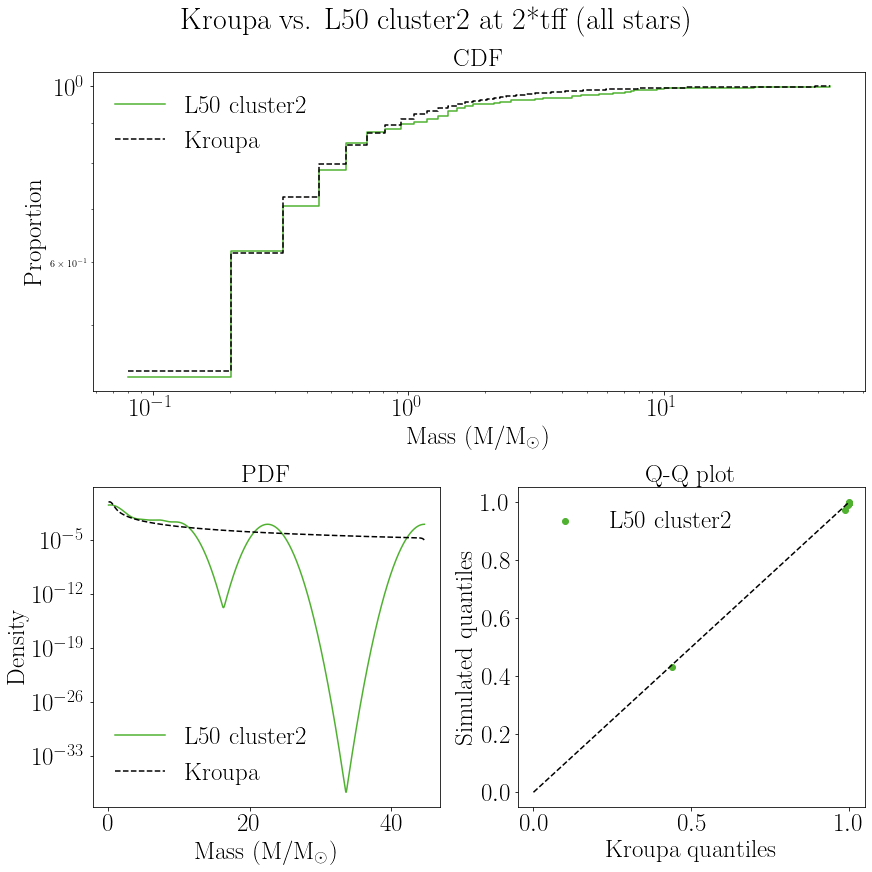


*************************************************************

           L50 cluster3 STATISTICS 

Comparing cluster total mass to Kroupa total: 267.4232198095276 267.4232289055792

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.238' '0.265']
 ['10%' '0.961' '0.971']
 ['20%' '0.978' '0.989']
 ['30%' '0.993' '0.994']
 ['40%' '0.995' '0.996']
 ['50%' '0.995' '0.998']
 ['60%' '0.995' '0.998']
 ['70%' '0.995' '0.999']
 ['80%' '0.995' '0.999']
 ['90%' '0.998' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.379   --    -

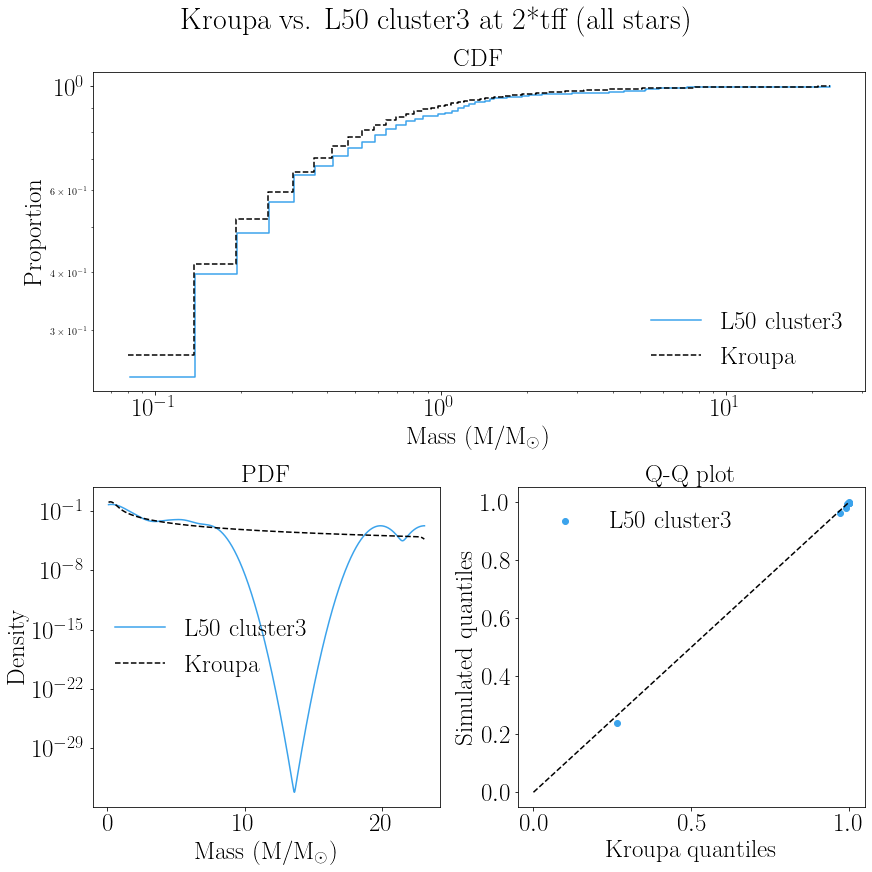


*************************************************************

           L70 cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 332.21525982710773 332.2152711269744

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.207' '0.25']
 ['10%' '0.976' '0.979']
 ['20%' '0.992' '0.992']
 ['30%' '0.997' '0.996']
 ['40%' '0.997' '0.997']
 ['50%' '0.997' '0.998']
 ['60%' '0.998' '0.999']
 ['70%' '0.998' '0.999']
 ['80%' '0.998' '1.0']
 ['90%' '0.998' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --    -- 

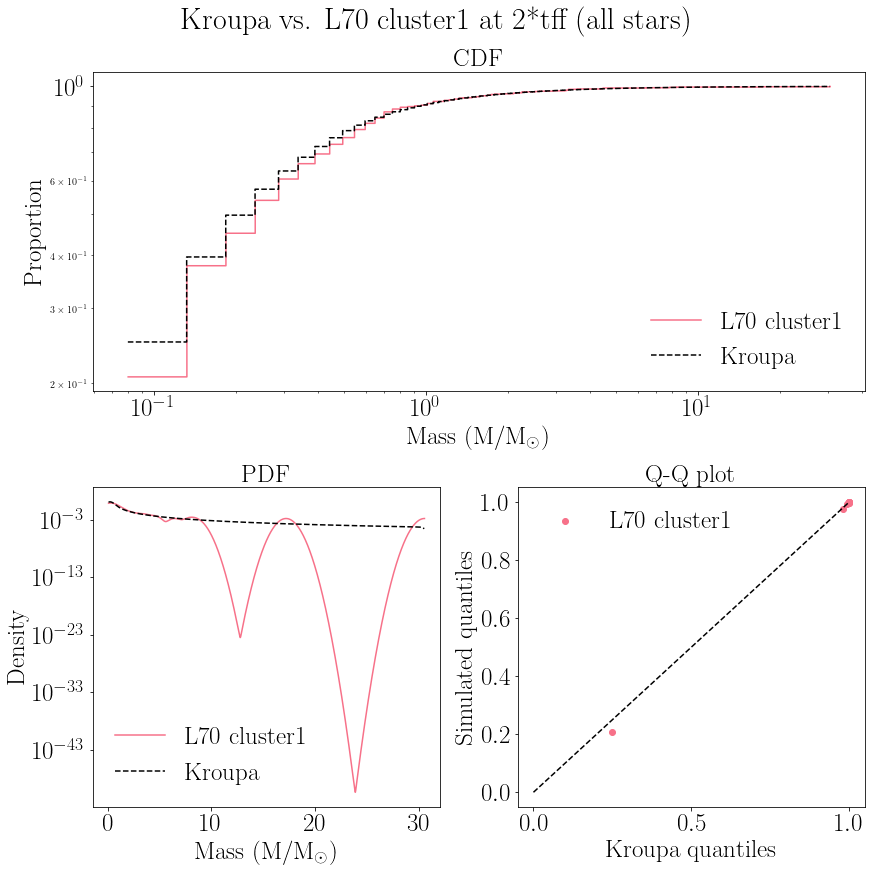


*************************************************************

           L70 cluster2 STATISTICS 

Comparing cluster total mass to Kroupa total: 238.84133240545134 238.84134052932572

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.234' '0.272']
 ['10%' '0.982' '0.975']
 ['20%' '0.991' '0.99']
 ['30%' '0.995' '0.995']
 ['40%' '0.995' '0.997']
 ['50%' '0.998' '0.998']
 ['60%' '0.998' '0.999']
 ['70%' '0.998' '0.999']
 ['80%' '0.998' '1.0']
 ['90%' '0.998' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.379   --    --

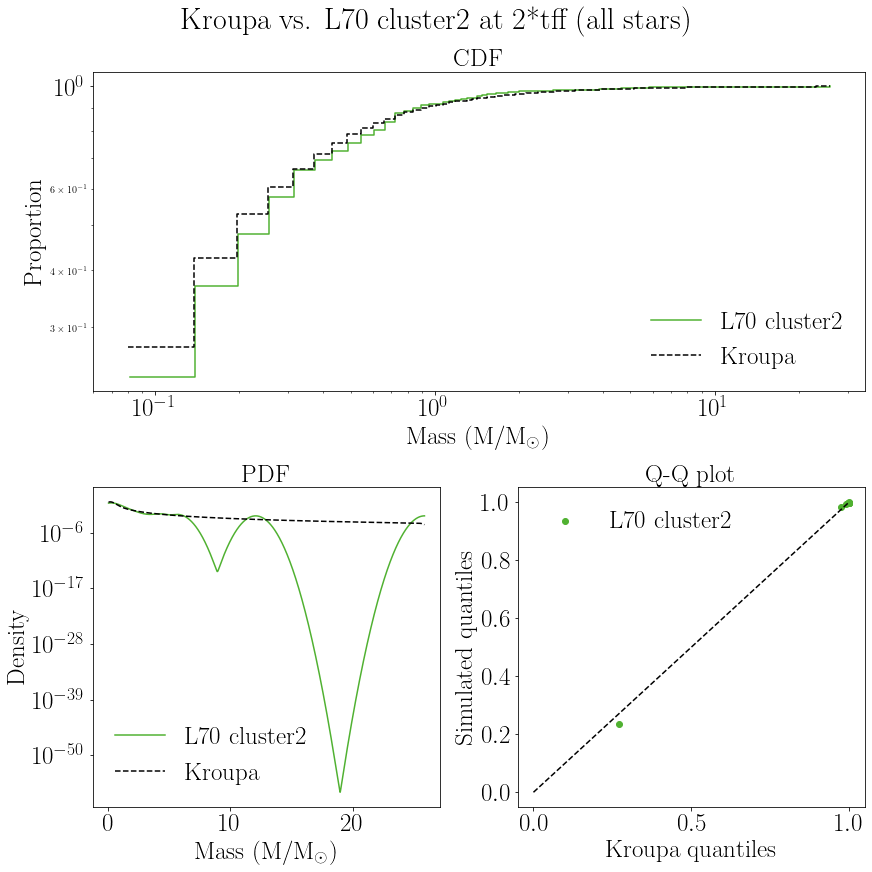


*************************************************************

           L70 cluster3 STATISTICS 

Comparing cluster total mass to Kroupa total: 185.00484947324514 185.00485576594343

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.564' '0.593']
 ['10%' '0.992' '0.991']
 ['20%' '0.995' '0.997']
 ['30%' '0.996' '0.998']
 ['40%' '0.996' '0.999']
 ['50%' '0.996' '0.999']
 ['60%' '0.996' '1.0']
 ['70%' '0.996' '1.0']
 ['80%' '0.996' '1.0']
 ['90%' '0.996' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.378   --    --   

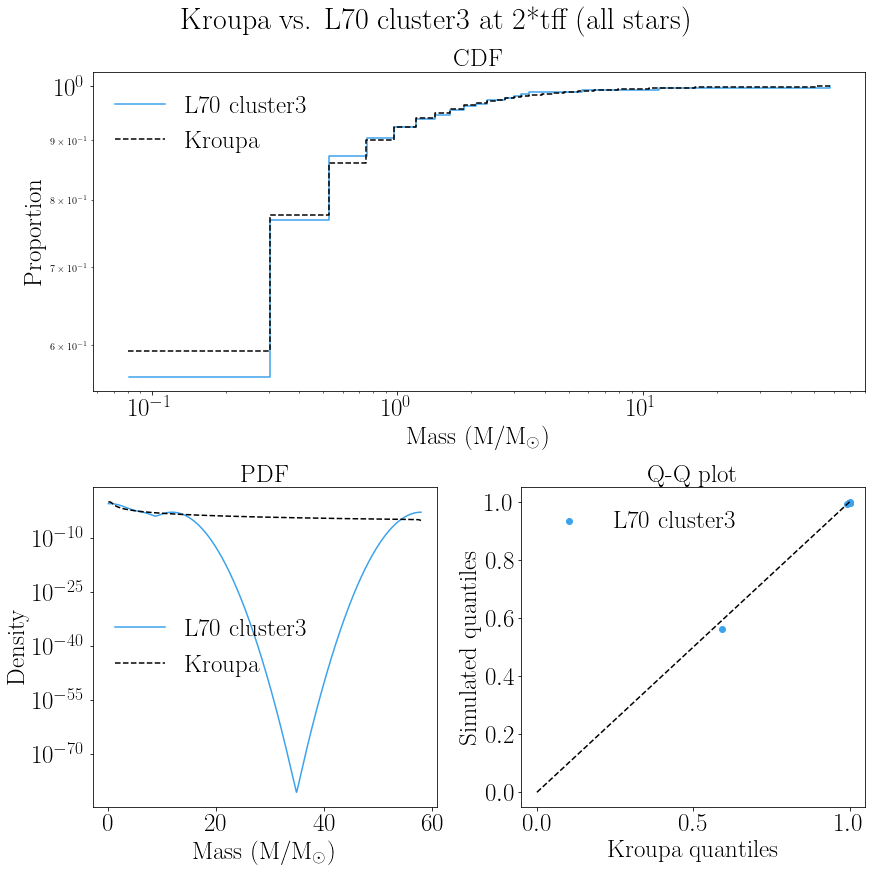


*************************************************************

           L100 cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 402.9737609269377 402.97377463355974

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.124' '0.157']
 ['10%' '0.948' '0.962']
 ['20%' '0.985' '0.985']
 ['30%' '0.986' '0.992']
 ['40%' '0.991' '0.995']
 ['50%' '0.991' '0.997']
 ['60%' '0.992' '0.998']
 ['70%' '0.994' '0.999']
 ['80%' '0.998' '0.999']
 ['90%' '0.998' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --   

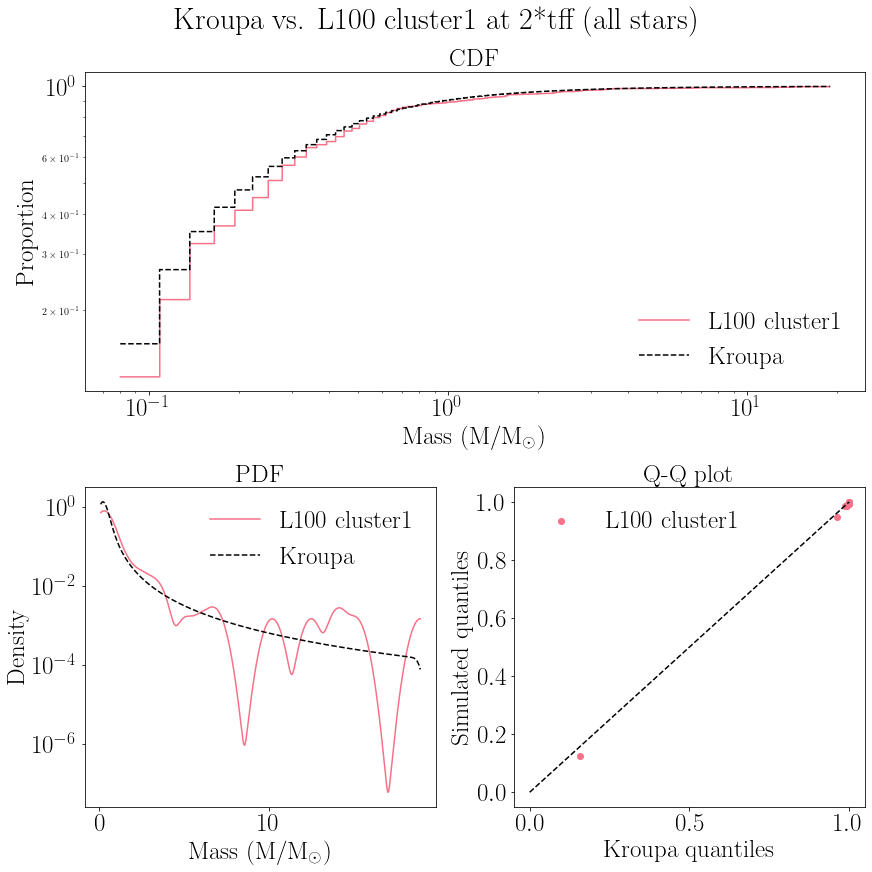


*************************************************************

           L100 cluster2 STATISTICS 

Comparing cluster total mass to Kroupa total: 221.18576880844526 221.18577633178816

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.182' '0.214']
 ['10%' '0.952' '0.954']
 ['20%' '0.979' '0.982']
 ['30%' '0.982' '0.99']
 ['40%' '0.989' '0.994']
 ['50%' '0.989' '0.996']
 ['60%' '0.992' '0.998']
 ['70%' '0.995' '0.998']
 ['80%' '0.997' '0.999']
 ['90%' '0.997' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.378   --   

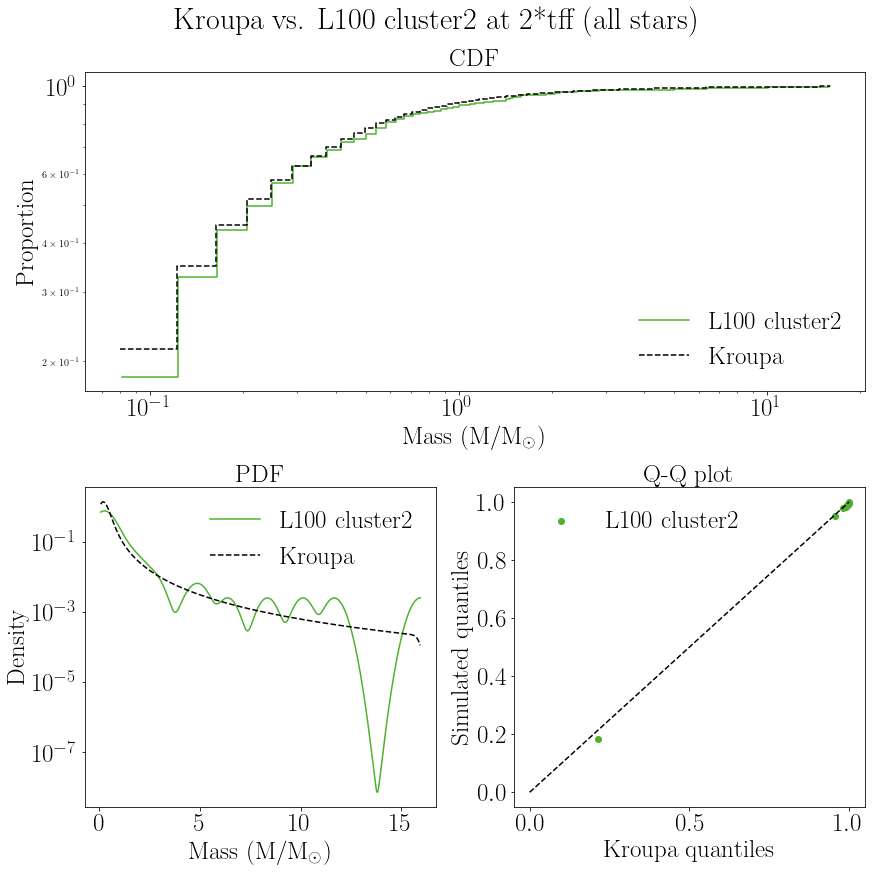


*************************************************************

           L100 cluster3 STATISTICS 

Comparing cluster total mass to Kroupa total: 54.55978900257147 54.55979085835142

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.185' '0.203']
 ['10%' '0.819' '0.836']
 ['20%' '0.948' '0.931']
 ['30%' '0.97' '0.961']
 ['40%' '0.985' '0.976']
 ['50%' '0.985' '0.985']
 ['60%' '0.985' '0.99']
 ['70%' '0.993' '0.994']
 ['80%' '0.993' '0.996']
 ['90%' '0.993' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.380   --    

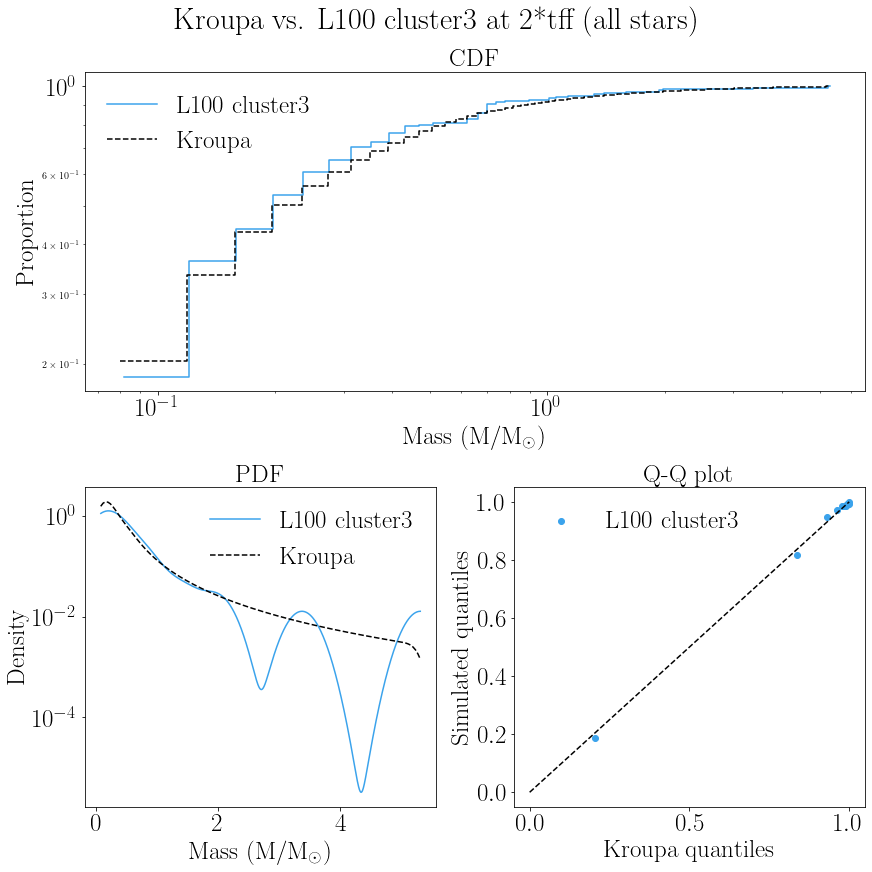


*************************************************************

           Lv cluster1 STATISTICS 

Comparing cluster total mass to Kroupa total: 3546.600309426868 3546.600430059832

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.0' '0.067']
 ['10%' '0.994' '0.992']
 ['20%' '0.997' '0.997']
 ['30%' '0.998' '0.998']
 ['40%' '0.999' '0.999']
 ['50%' '0.999' '0.999']
 ['60%' '1.0' '1.0']
 ['70%' '1.0' '1.0']
 ['80%' '1.0' '1.0']
 ['90%' '1.0' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --    --   0.000     0.0

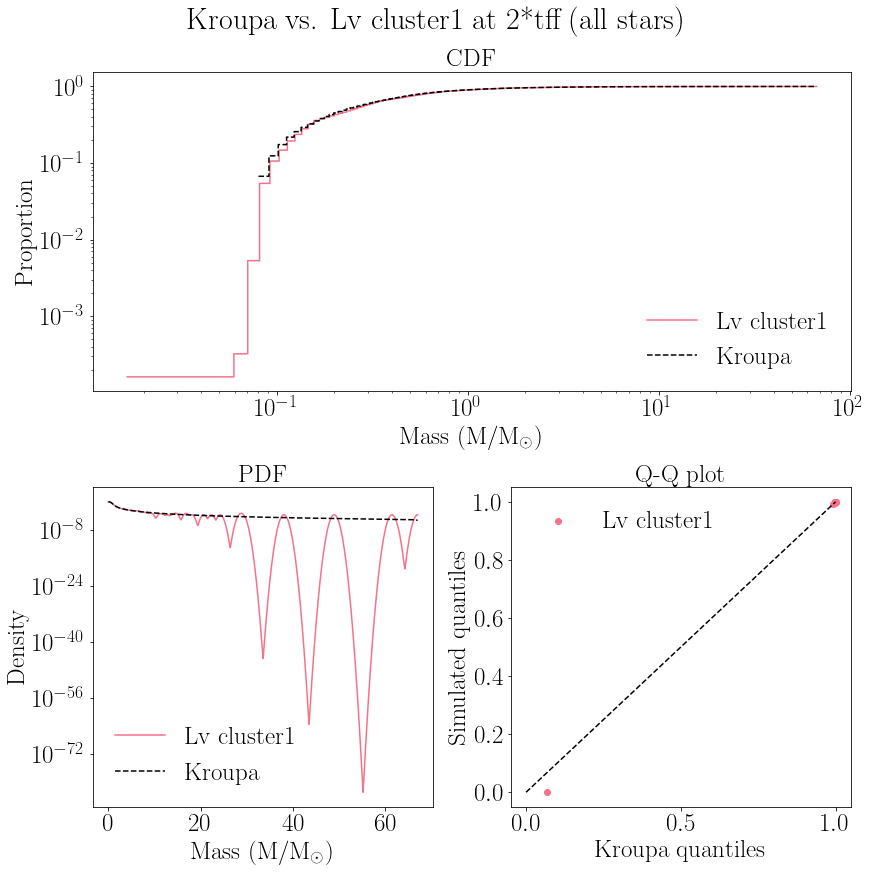

In [65]:
# KS test 
%matplotlib inline
palette_name = 'husl' #'rocket'  #icefire 
 
limits = [5, 8, None] # number of solar masses for upper limit 
cdf_container5 = CDF_container()
cdf_container8 = CDF_container()
cdf_container_all = CDF_container()
cdf_container_list = [cdf_container5, cdf_container8, cdf_container_all]

for limit in limits:
    if limit != None:
        print("\n####################################################\n\n Doing statistics for stars less than %d solar masses" % limit)
    else:
        print("\n####################################################\n\n Doing statistics for ALL stars")
    
    for name in ['L50', 'L70', 'L100', 'Lv']:
        sim = df[df['Simulation'] == name]
        palette = sns.color_palette(palette_name, len(np.unique(sim['Cluster']))) + [(0,0,0)]
        
        simulated_percentiles = []
        for idx, cluster_name in enumerate(np.unique(sim['Cluster'])):
            print("\n*************************************************************\n\n           %s STATISTICS \n" % cluster_name )
            
            fig, ax = plt.subplots(figsize=(12, 12), ncols=2, nrows=2, constrained_layout=True)
            gs = ax[0, 0].get_gridspec()
            # create sub plots as grid
            for axis in ax[0, :]:
                axis.remove()
            axbig = fig.add_subplot(gs[0, :])
            
            if limit != None:
                fig.suptitle(r'Kroupa vs. %s at 2*tff (M $\leq$ %d$M_{\odot}$)' % (cluster_name, limit), fontsize=30) #, y=.92)
            else:
                fig.suptitle(r'Kroupa vs. %s at 2*tff (all stars)' % cluster_name, fontsize=30) #, y=.92)

            d = sim[sim['Cluster'] == cluster_name]
            if limit != None:
                d = d[d['Mass'] <= limit]
     
            c = Cluster(d['Mass'], limit=limit)

            p = pd.DataFrame([x for x in d['Mass']], columns=['Mass'])
            sns.histplot(data=p, x='Mass', stat='density', cumulative=True, element='step', ax=axbig, bins=len(d['Mass']), color=palette[idx], fill=False, label=cluster_name)
             
            p = pd.DataFrame([x for x in d['Mass']], columns=['Mass'])
            sns.kdeplot(data=p, x='Mass',  ax=ax[1, 0], gridsize=10000, cut=0, color=palette[idx], label=cluster_name) #color='black')

            p = pd.DataFrame([x for x in zip(c.kroupa_x, c.kroupa_imf)], columns=['bins', 'counts'])
            sns.histplot(data=p, x='bins', weights='counts', stat='density', cumulative=True, element='step', ax=axbig, bins=len(d['Mass']), color='black', linestyle='--', label='Kroupa', fill=False)
        
            p = pd.DataFrame([x for x in zip(c.kroupa_x, c.kroupa_imf)], columns=['bins', 'counts'])
            sns.kdeplot(data=p, x='bins', weights='counts',  ax=ax[1, 0], gridsize=len(d['Mass']), cut=0, color='black', label='Kroupa', linestyle='--')

            lines = axbig.get_lines()
            labels = [str(line.get_label()) for line in lines]
            i = np.where(np.array(labels) == cluster_name)[0][0]
            x, cdf = lines[i].get_data()
            
            ii = np.where(np.array(labels) == 'Kroupa')[0][0]
            kx, kcdf = lines[ii].get_data()
            
            cdf_container_list[idx].update([cdf, kcdf], [cluster_name, 'Kroupa %s' % cluster_name])
            
#             ax[0].plot(c.kroupa_x, kcdf, color='r')
#             ax[0].hist(c.kroupa_x, weights=c.kroupa_imf, alpha=0.4, histtype='bar', cumulative=True, density=True, color='red', bins=10000)
                    
            # QQ plot
            q = np.arange(0,110,10)
            k_percentiles = np.percentile(kcdf, q)
            c_percentiles = np.percentile(cdf, q)
            percentiles = np.array([str(x)+"%" for x in q])
            print("\nComparing quantiles of CDFs:\n     Simulated  Kroupa\n", np.column_stack((percentiles, np.round(c_percentiles, decimals=3), np.round(k_percentiles, decimals=3))))
            ax[1,1].scatter(k_percentiles, c_percentiles, alpha=1, color=palette[idx], label=cluster_name)
            ax[1,1].plot([0,1], [0,1], linestyle='--', color='k')

            
            ########################################################################

            # KS test 
            print("\nKS test:\nx is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF")
            print("D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] \n")
            
            col_names = ("Null (H0)", "Alternative (H1)", "D+/D-", "D+", 'D-', "p-value", "Critical Val", "Accept?", "Conclusion")
            t = Table(names=col_names, dtype=('U1', 'U1', 'f8', 'f8', 'f8', 'f8', 'f8', 'U1', 'U1'), masked=True, meta={'name': "%s KS test" % cluster_name})
            for col in t.columns[2:7]:
                t[col].info.format = '.3f'
            t.columns[6].info.unit = '99% CL'
            alpha = [0.1, 0.05, 0.025, 0.01, 0.005, 0.001]
            c_alpha = [1.22, 1.36, 1.48, 1.63, 1.73, 1.95]
            critical_vals = np.array([c/np.sqrt(len(d['Mass'])) for c in c_alpha])
            
            # two sided -> have to use alpha/2 to find critical value 
            CL = [str((1-(2*a)*100)) + "%" for a in alpha]
           
            stat, p = stats.ks_1samp(d['Mass'], c.kroupa.cdf)
            a, crit_val, confidence = 2*alpha[4], critical_vals[4], CL[4]  
            
            # compare D value to critical value at 99% confidence
            if stat < crit_val:
                row = ['F(x) = G(x)', 'F(x) not G(x)', stat, 0, 0, p, crit_val, "H0", 'F(x) = G(x)']
            else:
                row = ['F(x) = G(x)', 'F(x) not G(x)', stat, 0, 0, p, crit_val, "H1", 'F(x) not G(x)']
            t.add_row(row)
            
            # one sided -> just use alpha to get critical value 
            CL = [str(1-a) + "%" for a in alpha]
            
            stat, p_minus = stats.ks_1samp(d['Mass'], c.kroupa.cdf, alternative='greater') 
            a, crit_val, confidence = alpha[3], critical_vals[3], CL[3]  
            
            # compare D value to critical value at 99% confidence
            if stat < crit_val:
                row = ['F(x) <= G(x)', 'F(x) > G(x)', 0, stat, 0, p_minus, crit_val, "H0", 'F(x) <= G(x)']
            else:
                row = ['F(x) <= G(x)', 'F(x) > G(x)', 0, stat, 0, p_minus, crit_val, "H1", 'F(x) > G(x)']
            t.add_row(row)
            
            stat, p_plus = stats.ks_1samp(d['Mass'], c.kroupa.cdf, alternative='less') 
            a, crit_val, confidence = alpha[3], critical_vals[3], CL[3]  
            
            # compare D value to critical value at 99% confidence
            if stat < crit_val:
                row = ['F(x) >= G(x)', 'F(x) < G(x)', 0, 0, stat, p_plus, crit_val, "H0", 'F(x) >= G(x)']
            else:
                row = ['F(x) >= G(x)', 'F(x) < G(x)', 0, 0, stat, p_plus, crit_val, "H1", 'F(x) < G(x)']
            t.add_row(row)
            
            t['D+/D-'].mask = [False, True, True]
            t['D+'].mask = [True, False, True]
            t['D-'].mask = [True, True, False]
            t.pprint_all(align='^')
            
             #relabel axes:
            axbig.set_title('CDF', fontsize=25)
            axbig.set_ylabel('Proportion', fontsize=25)
            if log_cdf_x == True: axbig.set_xscale('log')
            if log_cdf_y == True: axbig.set_yscale('log')
            axbig.set_xlabel(r'Mass (M/M$_\odot$)', fontsize=25)
            axbig.tick_params(axis='both', labelsize=25)
                             
            ax[1,0].set_title('PDF', fontsize=25)
            ax[1,0].set_ylabel('Density', fontsize=25)
            ax[1,0].set_xlabel(r'Mass (M/M$_\odot$)', fontsize=25)
            if log_pdf_y == True: ax[1,0].set_yscale('log')
            ax[1,0].tick_params(axis='both', labelsize=25)
            
            ax[1,1].set_title('Q-Q plot', fontsize=25)
            ax[1,1].set_ylabel('Simulated quantiles', fontsize=25)
            ax[1,1].set_xlabel('Kroupa quantiles', fontsize=25)
            ax[1,1].tick_params(axis='both', labelsize=25)

#             labels = np.unique(sim['Cluster']).tolist()+['Kroupa']
#             custom_lines = [Line2D([0], [0], color=color) for num,color in enumerate(palette[:-1])] + [Line2D([0], [0], color='k', linestyle='--')]
            
            axbig.legend(fontsize=25, frameon=False)
            ax[1,0].legend(fontsize=25, frameon=False)      
            ax[1,1].legend(fontsize=25, frameon=False)
            
            plt.show()
        
            if limit != None:
                fig.savefig('plots/%s_%dM_limit.png' % (cluster_name, limit))
            else:
                fig.savefig('plots/%s_all_stars.png' % cluster_name)
            #######################################################################
        
       

# now comparing distributions of all star in each simulation to Kroupa


####################################################

 Doing statistics for stars less than 5 solar masses

*************************************************************

           L50 STATISTICS 

Comparing cluster total mass to Kroupa total: 790.5595233625951 790.5595502524393

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.016' '0.02']
 ['10%' '0.777' '0.81']
 ['20%' '0.902' '0.922']
 ['30%' '0.948' '0.957']
 ['40%' '0.968' '0.973']
 ['50%' '0.979' '0.983']
 ['60%' '0.986' '0.989']
 ['70%' '0.991' '0.993']
 ['80%' '0.994' '0.996']
 ['90%' '0.998' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- -

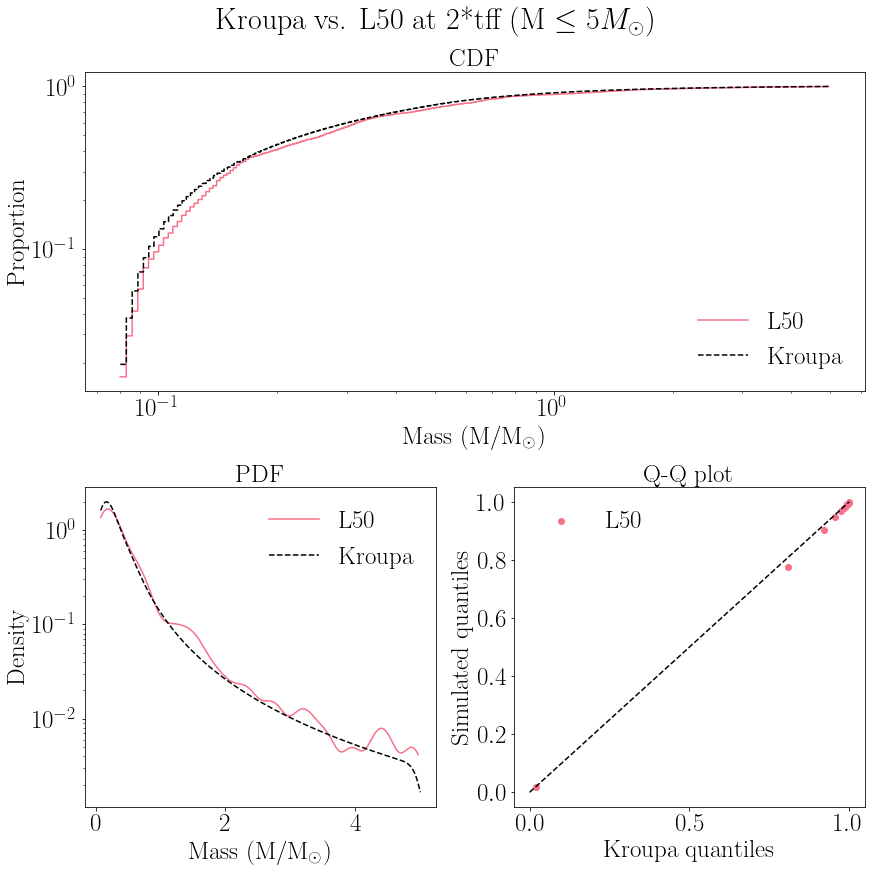


*************************************************************

           L70 STATISTICS 

Comparing cluster total mass to Kroupa total: 560.7823012841559 560.7823203584306

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.012' '0.026']
 ['10%' '0.764' '0.81']
 ['20%' '0.916' '0.922']
 ['30%' '0.953' '0.957']
 ['40%' '0.971' '0.973']
 ['50%' '0.981' '0.983']
 ['60%' '0.986' '0.989']
 ['70%' '0.989' '0.993']
 ['80%' '0.995' '0.996']
 ['90%' '0.996' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --    --   0.00

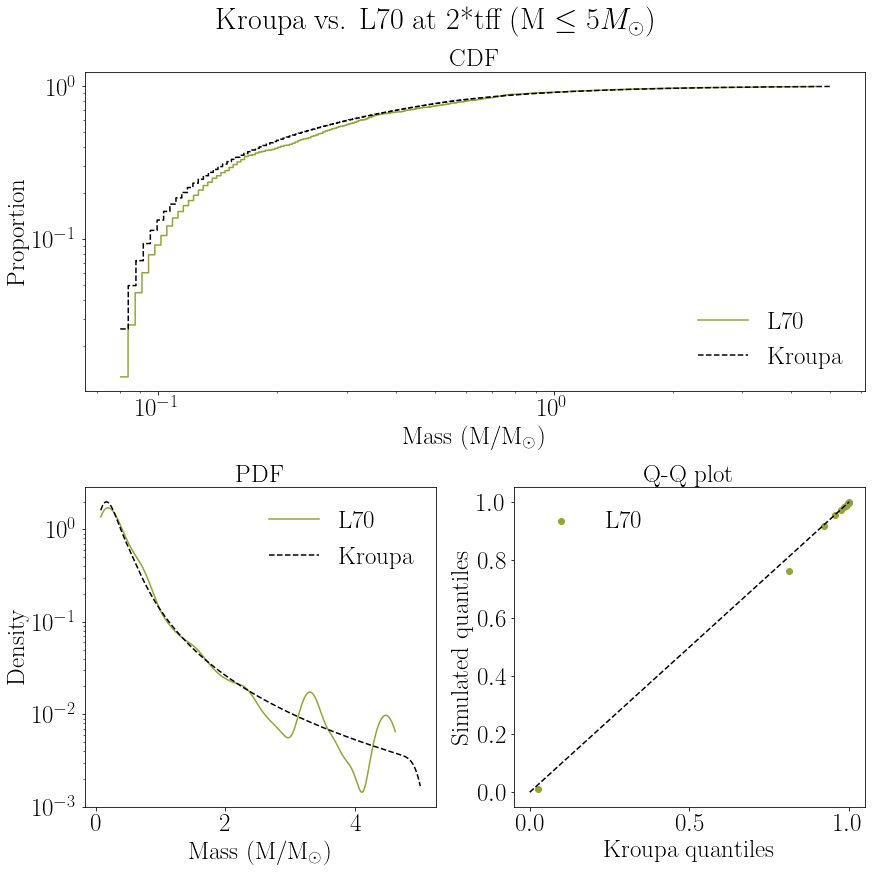


*************************************************************

           L100 STATISTICS 

Comparing cluster total mass to Kroupa total: 506.80399018022246 506.8040074184955

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.025' '0.028']
 ['10%' '0.799' '0.811']
 ['20%' '0.913' '0.922']
 ['30%' '0.951' '0.957']
 ['40%' '0.969' '0.973']
 ['50%' '0.983' '0.983']
 ['60%' '0.991' '0.989']
 ['70%' '0.997' '0.993']
 ['80%' '0.998' '0.996']
 ['90%' '0.998' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.377   --    --   0

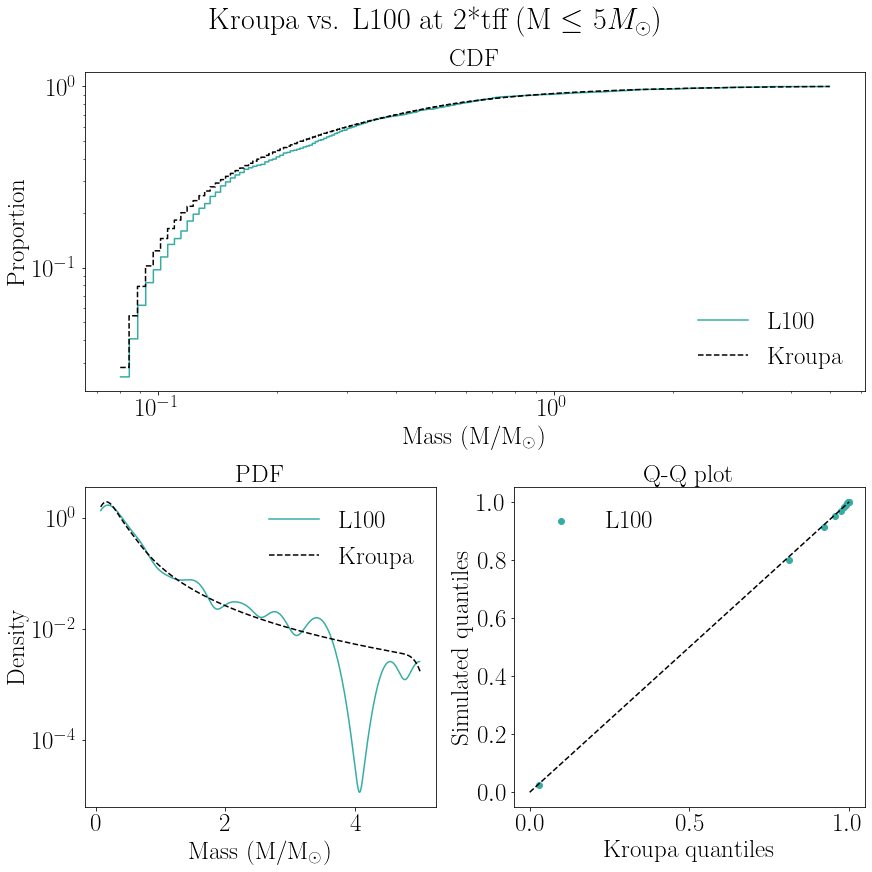


*************************************************************

           Lv STATISTICS 

Comparing cluster total mass to Kroupa total: 2713.0908977768577 2713.0909900590877

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.0' '0.006']
 ['10%' '0.758' '0.809']
 ['20%' '0.907' '0.921']
 ['30%' '0.954' '0.957']
 ['40%' '0.974' '0.973']
 ['50%' '0.981' '0.983']
 ['60%' '0.988' '0.989']
 ['70%' '0.993' '0.993']
 ['80%' '0.995' '0.996']
 ['90%' '0.998' '0.998']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --    --   0.00

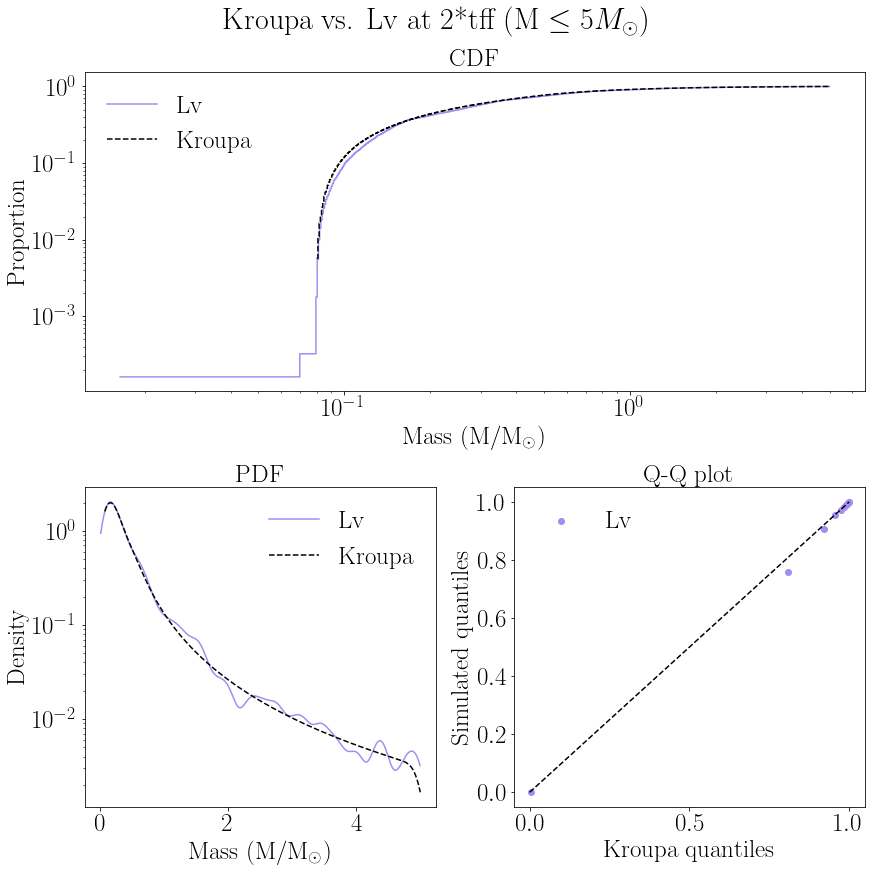


####################################################

 Doing statistics for stars less than 8 solar masses

*************************************************************

           L50 STATISTICS 

Comparing cluster total mass to Kroupa total: 925.4640579787138 925.4640894571634

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.023' '0.03']
 ['10%' '0.866' '0.89']
 ['20%' '0.943' '0.956']
 ['30%' '0.965' '0.976']
 ['40%' '0.974' '0.985']
 ['50%' '0.981' '0.991']
 ['60%' '0.985' '0.994']
 ['70%' '0.99' '0.996']
 ['80%' '0.994' '0.998']
 ['90%' '0.998' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- --

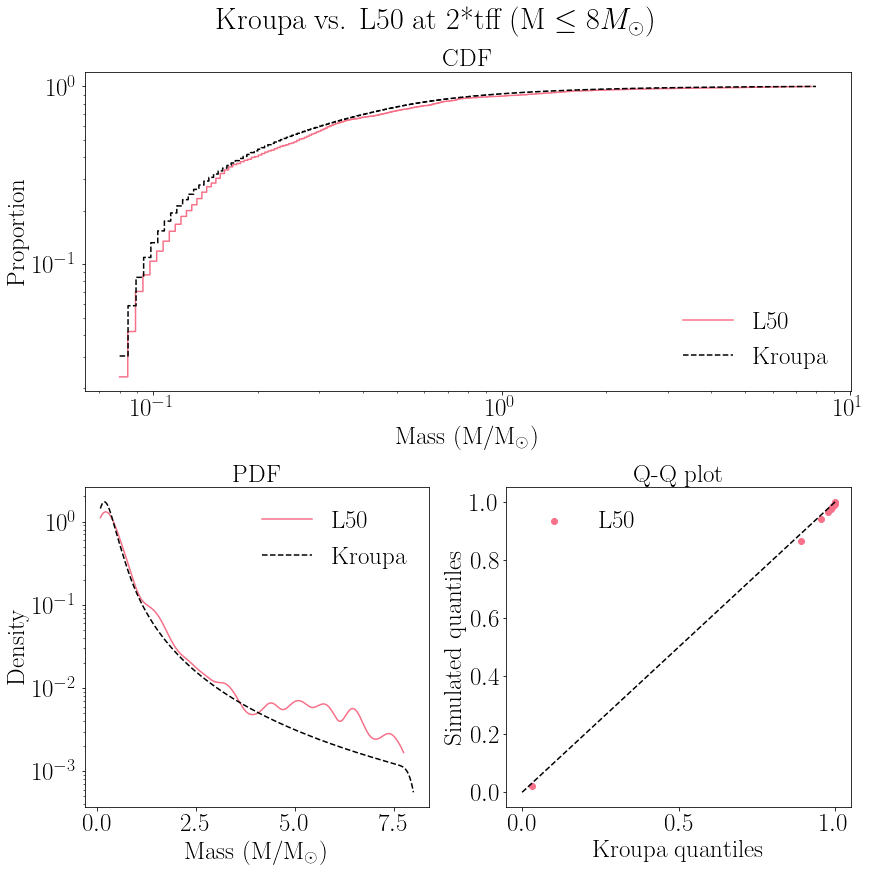


*************************************************************

           L70 STATISTICS 

Comparing cluster total mass to Kroupa total: 592.2328843677715 592.2329045117948

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.026' '0.04']
 ['10%' '0.895' '0.891']
 ['20%' '0.96' '0.956']
 ['30%' '0.979' '0.976']
 ['40%' '0.984' '0.985']
 ['50%' '0.992' '0.991']
 ['60%' '0.996' '0.994']
 ['70%' '0.996' '0.996']
 ['80%' '0.998' '0.998']
 ['90%' '0.999' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --    --   0.000

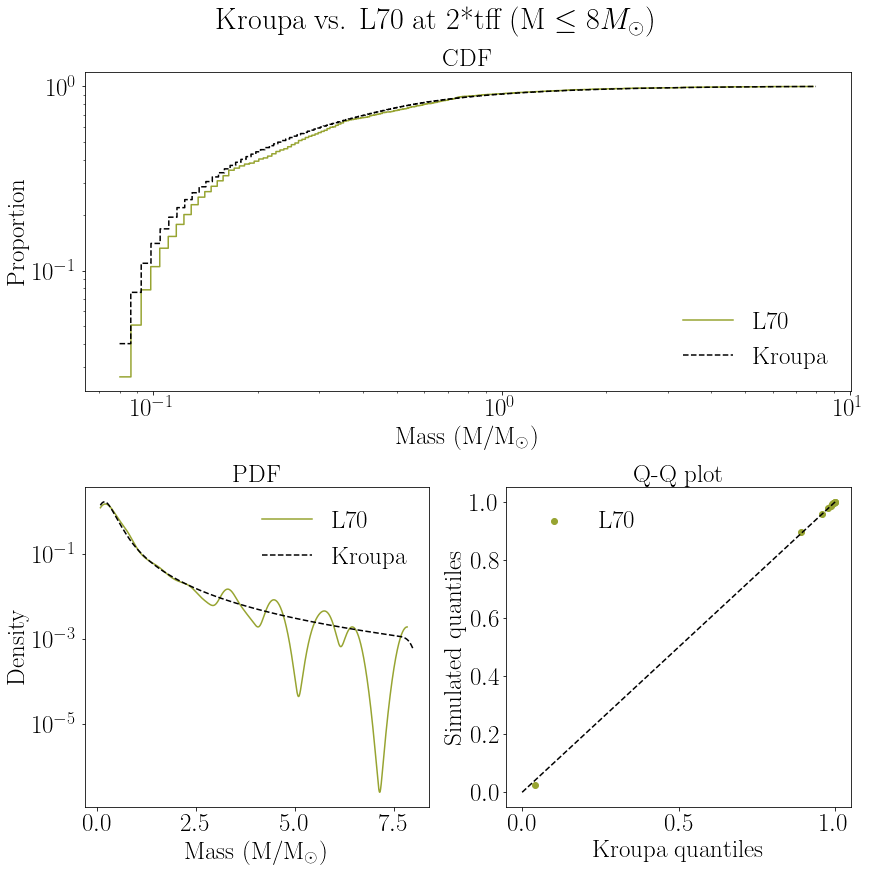


*************************************************************

           L100 STATISTICS 

Comparing cluster total mass to Kroupa total: 547.9009356645906 547.900954300725

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.031' '0.044']
 ['10%' '0.874' '0.891']
 ['20%' '0.939' '0.956']
 ['30%' '0.967' '0.976']
 ['40%' '0.981' '0.985']
 ['50%' '0.991' '0.991']
 ['60%' '0.992' '0.994']
 ['70%' '0.993' '0.996']
 ['80%' '0.997' '0.998']
 ['90%' '0.997' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.377   --    --   0.0

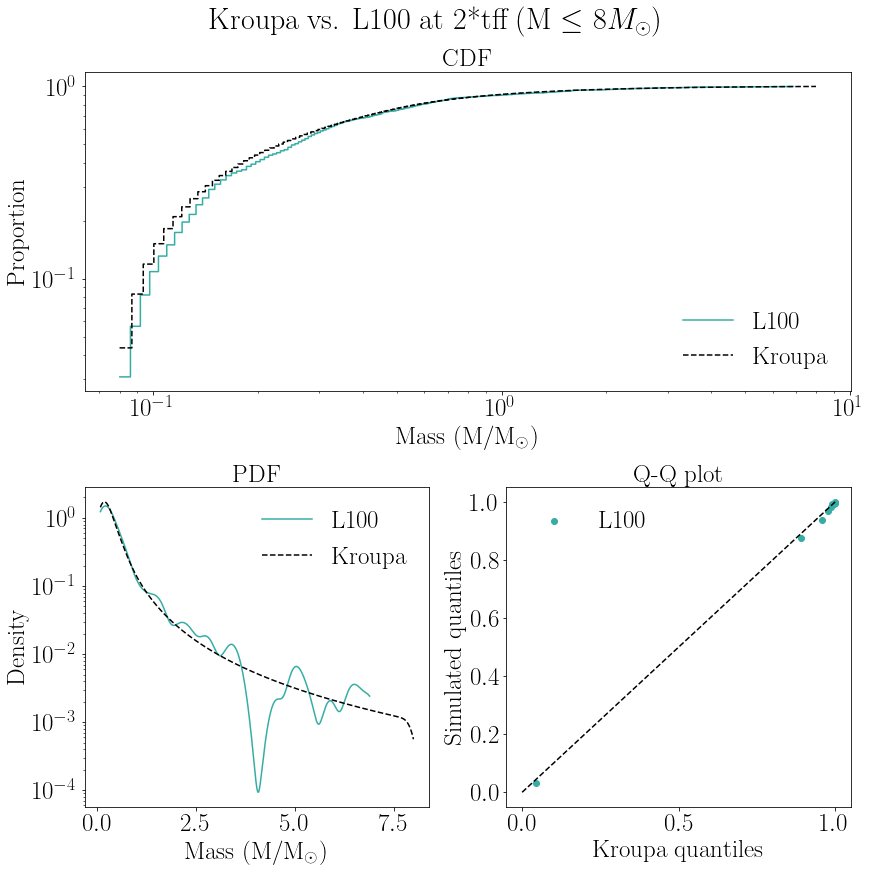


*************************************************************

           Lv STATISTICS 

Comparing cluster total mass to Kroupa total: 2958.8226092404384 2958.822709880926

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.0' '0.009']
 ['10%' '0.874' '0.89']
 ['20%' '0.956' '0.956']
 ['30%' '0.973' '0.976']
 ['40%' '0.984' '0.985']
 ['50%' '0.989' '0.991']
 ['60%' '0.993' '0.994']
 ['70%' '0.995' '0.996']
 ['80%' '0.997' '0.998']
 ['90%' '0.999' '0.999']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --    --   0.000 

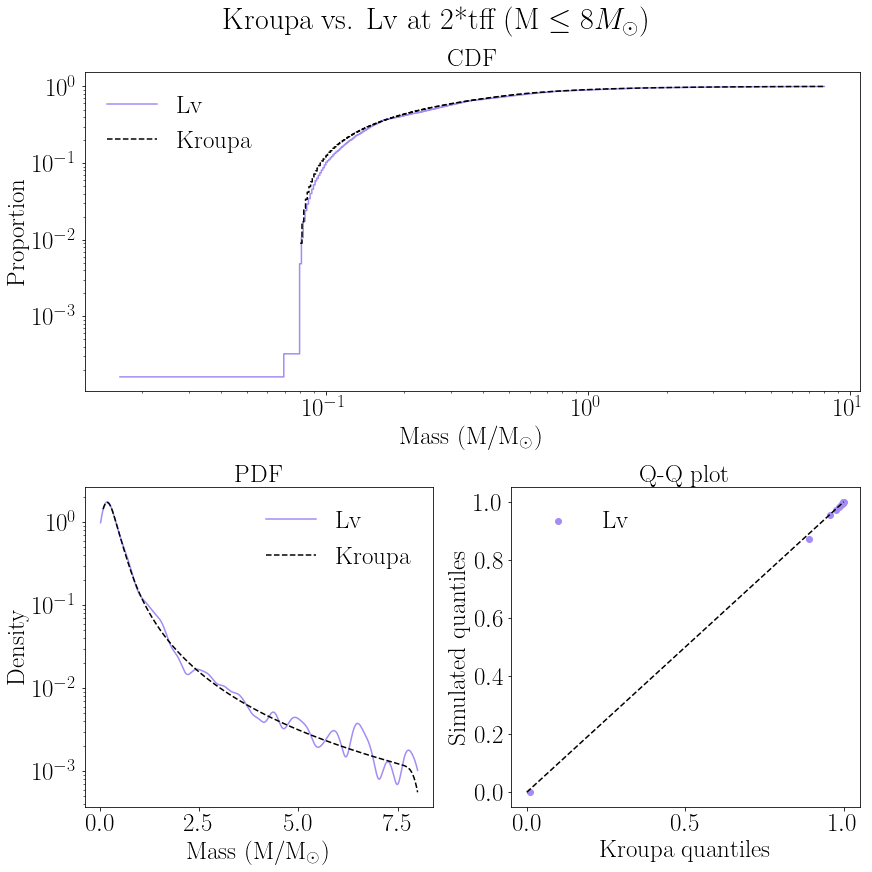


####################################################

 Doing statistics for ALL stars

*************************************************************

           L50 STATISTICS 

Comparing cluster total mass to Kroupa total: 1089.2095054962253 1089.2095425442596

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.115' '0.145']
 ['10%' '0.98' '0.987']
 ['20%' '0.995' '0.995']
 ['30%' '0.998' '0.997']
 ['40%' '0.998' '0.998']
 ['50%' '0.998' '0.999']
 ['60%' '0.999' '0.999']
 ['70%' '0.999' '1.0']
 ['80%' '0.999' '1.0']
 ['90%' '0.999' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- -----

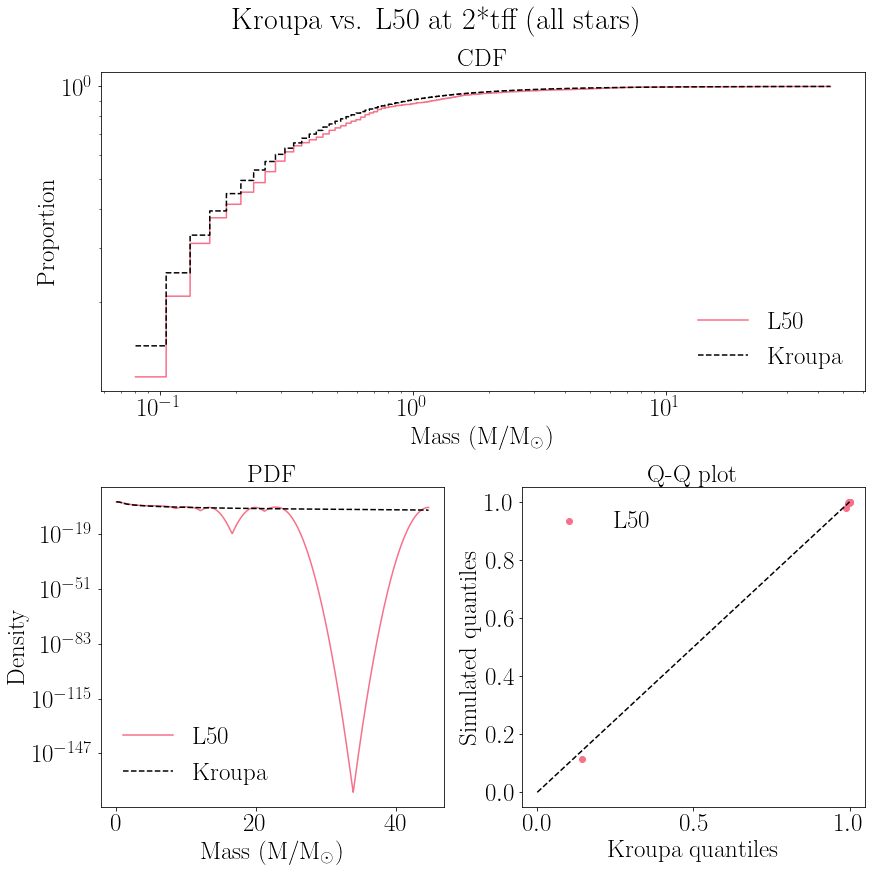


*************************************************************

           L70 STATISTICS 

Comparing cluster total mass to Kroupa total: 756.0614417058036 756.0614674222458

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.186' '0.224']
 ['10%' '0.993' '0.991']
 ['20%' '0.995' '0.997']
 ['30%' '0.998' '0.998']
 ['40%' '0.998' '0.999']
 ['50%' '0.998' '0.999']
 ['60%' '0.999' '1.0']
 ['70%' '0.999' '1.0']
 ['80%' '0.999' '1.0']
 ['90%' '0.999' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --    --   0.000     0

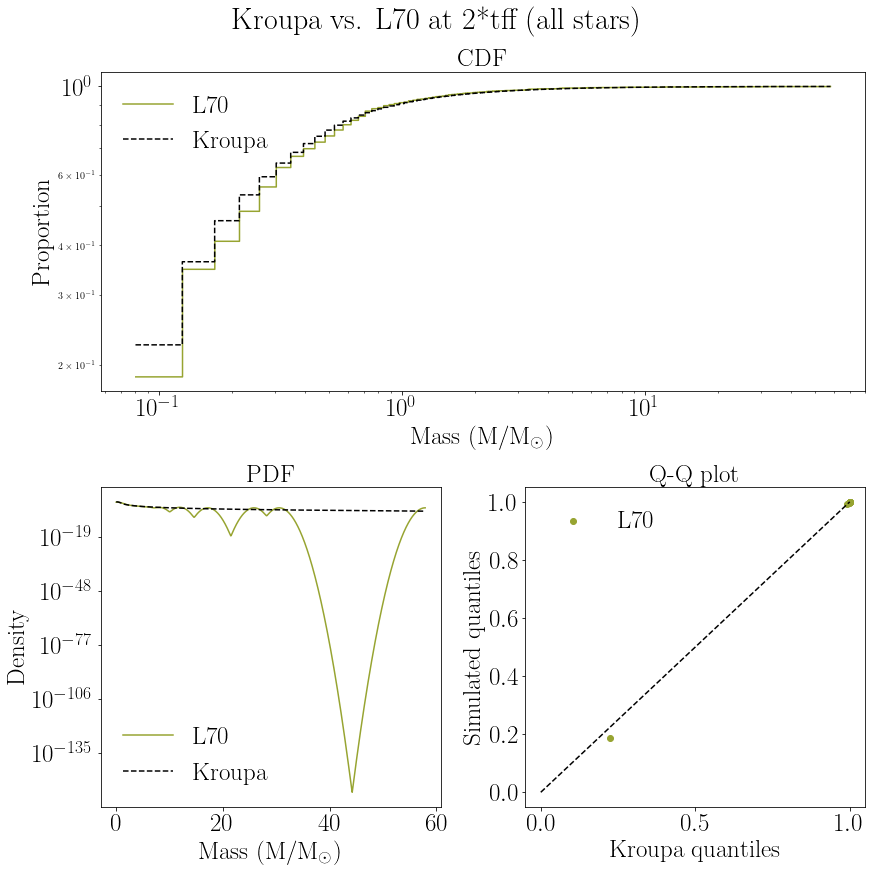


*************************************************************

           L100 STATISTICS 

Comparing cluster total mass to Kroupa total: 678.7193187379544 678.7193418237022

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.077' '0.096']
 ['10%' '0.953' '0.962']
 ['20%' '0.984' '0.985']
 ['30%' '0.988' '0.992']
 ['40%' '0.992' '0.995']
 ['50%' '0.992' '0.997']
 ['60%' '0.994' '0.998']
 ['70%' '0.996' '0.999']
 ['80%' '0.998' '0.999']
 ['90%' '0.999' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.377   --    --   0.00

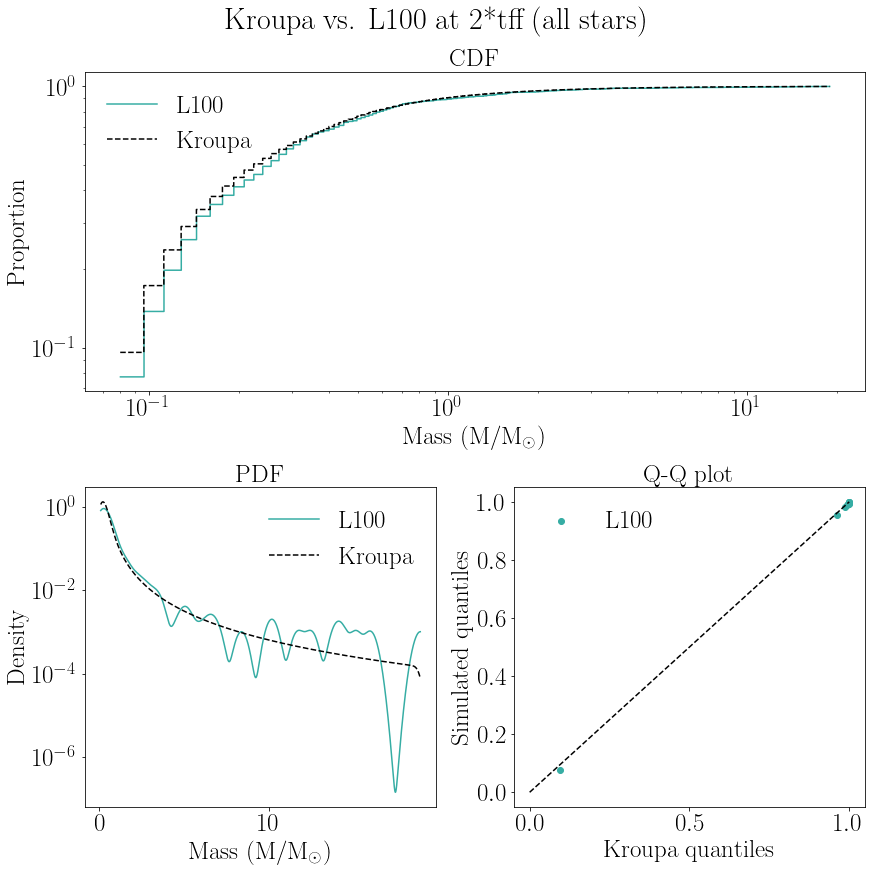


*************************************************************

           Lv STATISTICS 

Comparing cluster total mass to Kroupa total: 3546.600309426868 3546.600430059832

Comparing quantiles of CDFs:
     Simulated  Kroupa
 [['0%' '0.0' '0.067']
 ['10%' '0.994' '0.992']
 ['20%' '0.997' '0.997']
 ['30%' '0.998' '0.998']
 ['40%' '0.999' '0.999']
 ['50%' '0.999' '0.999']
 ['60%' '1.0' '1.0']
 ['70%' '1.0' '1.0']
 ['80%' '1.0' '1.0']
 ['90%' '1.0' '1.0']
 ['100%' '1.0' '1.0']]

KS test:
x is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF
D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] 

 Null (H0)   Alternative (H1) D+/D-   D+    D-  p-value Critical Val Accept?   Conclusion 
                                                           99% CL                         
------------ ---------------- ----- ----- ----- ------- ------------ ------- -------------
F(x) = G(x)   F(x) not G(x)   0.376   --    --   0.000     0.022       

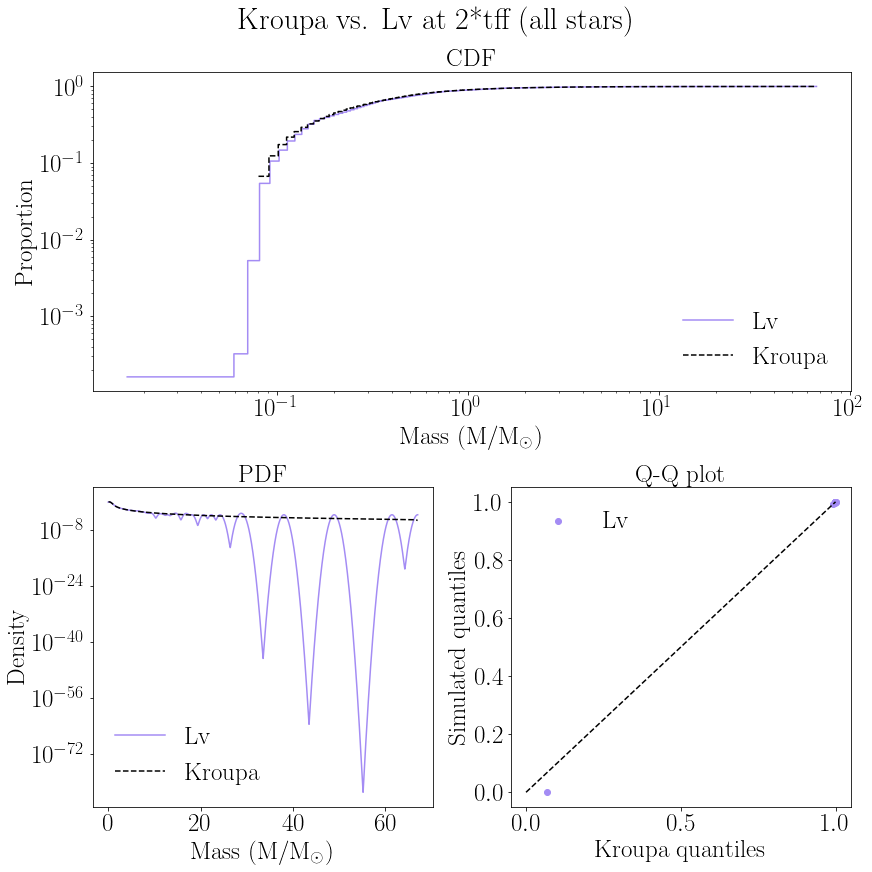

In [66]:
palette_name = 'husl' #'rocket'  #icefire 
 
limits = [5, 8, None] # number of solar masses for upper limit 

for limit in limits:
    if limit != None:
        print("\n####################################################\n\n Doing statistics for stars less than %d solar masses" % limit)
    else:
        print("\n####################################################\n\n Doing statistics for ALL stars")
    
    for idx, (sim, name) in enumerate(zip([L50, L70, L100, Lv], ['L50', 'L70', 'L100', 'Lv'])):
        sim = df[df['Simulation'] == name]
        palette = sns.color_palette(palette_name, 4) + [(0,0,0)]

        print("\n*************************************************************\n\n           %s STATISTICS \n" % name )

        fig, ax = plt.subplots(figsize=(12, 12), ncols=2, nrows=2, constrained_layout=True)
        gs = ax[0, 0].get_gridspec()
        # create sub plots as grid
        for axis in ax[0, :]:
            axis.remove()
        axbig = fig.add_subplot(gs[0, :])

        if limit != None:
            fig.suptitle(r'Kroupa vs. %s at 2*tff (M $\leq$ %d$M_{\odot}$)' % (name, limit), fontsize=30) #, y=.92)
        else:
            fig.suptitle(r'Kroupa vs. %s at 2*tff (all stars)' % name, fontsize=30) #, y=.92)

        if limit != None:
            d = sim[sim['Mass'] <= limit]
        else: d = sim

        c = Cluster(d['Mass'], limit=limit)

        p = pd.DataFrame([x for x in d['Mass']], columns=['Mass'])
        sns.histplot(data=p, x='Mass', stat='density', cumulative=True, element='step', ax=axbig, bins=len(d['Mass']), color=palette[idx], fill=False, label=name)

        p = pd.DataFrame([x for x in d['Mass']], columns=['Mass'])
        sns.kdeplot(data=p, x='Mass',  ax=ax[1, 0], gridsize=10000, cut=0, color=palette[idx], label=name) #color='black')

        p = pd.DataFrame([x for x in zip(c.kroupa_x, c.kroupa_imf)], columns=['bins', 'counts'])
        sns.histplot(data=p, x='bins', weights='counts', stat='density', cumulative=True, element='step', ax=axbig, bins=len(d['Mass']), color='black', linestyle='--', label='Kroupa', fill=False)

        p = pd.DataFrame([x for x in zip(c.kroupa_x, c.kroupa_imf)], columns=['bins', 'counts'])
        sns.kdeplot(data=p, x='bins', weights='counts',  ax=ax[1, 0], gridsize=len(d['Mass']), cut=0, color='black', label='Kroupa', linestyle='--')

        lines = axbig.get_lines()
        labels = [str(line.get_label()) for line in lines]
        i = np.where(np.array(labels) == name)[0][0]
        x, cdf = lines[i].get_data()

        ii = np.where(np.array(labels) == 'Kroupa')[0][0]
        kx, kcdf = lines[ii].get_data()
        
        
#             ax[0].plot(c.kroupa_x, kcdf, color='r')
#             ax[0].hist(c.kroupa_x, weights=c.kroupa_imf, alpha=0.4, histtype='bar', cumulative=True, density=True, color='red', bins=10000)

        # QQ plot
        q = np.arange(0,110,10)
        k_percentiles = np.percentile(kcdf, q)
        c_percentiles = np.percentile(cdf, q)
        percentiles = np.array([str(x)+"%" for x in q])
        print("\nComparing quantiles of CDFs:\n     Simulated  Kroupa\n", np.column_stack((percentiles, np.round(c_percentiles, decimals=3), np.round(k_percentiles, decimals=3))))
        ax[1,1].scatter(k_percentiles, c_percentiles, alpha=1, color=palette[idx], label=name)
        ax[1,1].plot([0,1], [0,1], linestyle='--', color='k')


        ########################################################################

        # KS test 
        print("\nKS test:\nx is observed values from simulated distribution, F(x) is its underlying CDF, G(x) is Kroupa CDF")
        print("D value is distance of Kroupa CDF - simulated CDF: max[G(x)-F(x)] \n")

        col_names = ("Null (H0)", "Alternative (H1)", "D+/D-", "D+", 'D-', "p-value", "Critical Val", "Accept?", "Conclusion")
        t = Table(names=col_names, dtype=('U1', 'U1', 'f8', 'f8', 'f8', 'f8', 'f8', 'U1', 'U1'), masked=True, meta={'name': "%s KS test" % cluster_name})
        for col in t.columns[2:7]:
            t[col].info.format = '.3f'
        t.columns[6].info.unit = '99% CL'
        alpha = [0.1, 0.05, 0.025, 0.01, 0.005, 0.001]
        c_alpha = [1.22, 1.36, 1.48, 1.63, 1.73, 1.95]
        critical_vals = np.array([c/np.sqrt(len(d['Mass'])) for c in c_alpha])

        # two sided -> have to use alpha/2 to find critical value 
        CL = [str((1-(2*a)*100)) + "%" for a in alpha]

        stat, p = stats.ks_1samp(d['Mass'], c.kroupa.cdf)
        a, crit_val, confidence = 2*alpha[4], critical_vals[4], CL[4]  

        # compare D value to critical value at 99% confidence
        if stat < crit_val:
            row = ['F(x) = G(x)', 'F(x) not G(x)', stat, 0, 0, p, crit_val, "H0", 'F(x) = G(x)']
        else:
            row = ['F(x) = G(x)', 'F(x) not G(x)', stat, 0, 0, p, crit_val, "H1", 'F(x) not G(x)']
        t.add_row(row)

        # one sided -> just use alpha to get critical value 
        CL = [str(1-a) + "%" for a in alpha]

        stat, p_minus = stats.ks_1samp(d['Mass'], c.kroupa.cdf, alternative='greater') 
        a, crit_val, confidence = alpha[3], critical_vals[3], CL[3]  

        # compare D value to critical value at 99% confidence
        if stat < crit_val:
            row = ['F(x) <= G(x)', 'F(x) > G(x)', 0, stat, 0, p_minus, crit_val, "H0", 'F(x) <= G(x)']
        else:
            row = ['F(x) <= G(x)', 'F(x) > G(x)', 0, stat, 0, p_minus, crit_val, "H1", 'F(x) > G(x)']
        t.add_row(row)

        stat, p_plus = stats.ks_1samp(d['Mass'], c.kroupa.cdf, alternative='less') 
        a, crit_val, confidence = alpha[3], critical_vals[3], CL[3]  

        # compare D value to critical value at 99% confidence
        if stat < crit_val:
            row = ['F(x) >= G(x)', 'F(x) < G(x)', 0, 0, stat, p_plus, crit_val, "H0", 'F(x) >= G(x)']
        else:
            row = ['F(x) >= G(x)', 'F(x) < G(x)', 0, 0, stat, p_plus, crit_val, "H1", 'F(x) < G(x)']
        t.add_row(row)

        t['D+/D-'].mask = [False, True, True]
        t['D+'].mask = [True, False, True]
        t['D-'].mask = [True, True, False]
        t.pprint_all(align='^')

         #relabel axes:
        axbig.set_title('CDF', fontsize=25)
        axbig.set_ylabel('Proportion', fontsize=25)
        axbig.set_xscale('log')
        axbig.set_yscale('log')
        axbig.set_xlabel(r'Mass (M/M$_\odot$)', fontsize=25)
        axbig.tick_params(axis='both', labelsize=25)

        ax[1,0].set_title('PDF', fontsize=25)
        ax[1,0].set_ylabel('Density', fontsize=25)
        ax[1,0].set_xlabel(r'Mass (M/M$_\odot$)', fontsize=25)
        ax[1,0].set_yscale('log')
        ax[1,0].tick_params(axis='both', labelsize=25)

        ax[1,1].set_title('Q-Q plot', fontsize=25)
        ax[1,1].set_ylabel('Simulated quantiles', fontsize=25)
        ax[1,1].set_xlabel('Kroupa quantiles', fontsize=25)
        ax[1,1].tick_params(axis='both', labelsize=25)

#             labels = np.unique(sim['Cluster']).tolist()+['Kroupa']
#             custom_lines = [Line2D([0], [0], color=color) for num,color in enumerate(palette[:-1])] + [Line2D([0], [0], color='k', linestyle='--')]

        axbig.legend(fontsize=25, frameon=False)
        ax[1,0].legend(fontsize=25, frameon=False)      
        ax[1,1].legend(fontsize=25, frameon=False)

        plt.show()

        if limit != None:
            fig.savefig('plots/%s_%dM_limit.png' % (name, limit))
        else:
            fig.savefig('plots/%s_all_stars.png' % name)
        #######################################################################



# extra stats tests for each cluster vs. kroupa
# still in progress - need to use correct kroupa CDF 

In [ ]:
limits = [5,8] # number of solar masses for upper limit 

for limit in limits:
    print("\n####################################################\n\n Doing statistics for stars less than %d solar masses" % limit)
    for name in ['L50', 'L70', 'L100', 'Lv']:
        d = df[df['Simulation'] == name]
        d = d[d['Mass'] <= limit]
        palette = sns.color_palette(palette_name, len(np.unique(d['Cluster']))) + [(0,0,0)]
        
        for i, cluster_name in enumerate(np.unique(d['Cluster'])):
            print("\n*************************************************************\n\n           %s STATISTICS \n" % cluster_name )

            c = d[d['Cluster'] == cluster_name]
            k = Kroupa(sum(c['Mass']), limit)

            # get cumulative distributions
            kroupa_cumsum = np.cumsum(np.array(k.counts)*np.array(k.bins))
            kroupa_cumsum /= kroupa_cumsum[-1]
            cumsum = np.cumsum(np.sort(c['Mass']))
            cumsum /= cumsum[-1]
            ax3[0].plot([np.log10(x) for x in np.sort(c['Mass'])], cumsum, color=palette[i], label=cluster_name)

            ########################################################################

            # descriptive stats:
            unique, counts = np.unique(np.sort(c['Mass']), return_counts=True)
            prob = counts/sum(counts)
            print('Descriptive statistics in solar masses:')
            print("          Simulation mean = %.3f, median = %.3f, standard dev = %.3f" % (np.average(c['Mass']), np.median(c['Mass']), np.std(c['Mass'])))
            idx = np.argmax(prob)
            print("          Most frequent/probable stellar mass: %.3f\n" % unique[idx])
            print("          Kroupa mean = %.3f, median = %.3f, standard dev = %.3f" % (np.average(k.bins), np.median(k.bins), np.std(k.bins)))
            idx = np.argmax(np.array(k.counts)/sum(k.counts))
            print("          Kroupa most frequent/probable stellar mass: %.3f\n" % unique[idx])

            ########################################################################

            # CVM test : compares underlying distribution of array of observed Xi... Xf values to a theoretical CDF
            res = stats.cramervonmises(c['Mass'], k.cdf)
            print("\nCramer von Mises test:")
            print("          stat = %.3f, p value = %.3f" % (res.statistic, res.pvalue))
            if res.pvalue < 0.01:
                print("----------> Simulated distribution doesn't come from Kroupa at the 99% confidence level (p = 0.01)")
                print("----------> NOT A GOOD FIT")

            ########################################################################

            # Kruskal Wallis test for independent samples via median

            stat, p = stats.kruskal(c['Mass'], k.bins)
            print("\nKrusal-Wallis analysis of variance:")
            print("          H stat = %.3f, p value = %.4f" % (stat, p))
            if p < 0.01:
                print("----------> Population medians are not equal at the 99% confidence level (p = 0.01)")
                print("----------> NOT A GOOD FIT")

            ########################################################################

    #       # Mann Whitney U test - compares underlying distribution of 2 arrays of observed Xi...Xf values (using bins)
            n, bins = np.histogram(c['Mass'], bins=np.logspace(0.08, 150, 10001))
            stat, p = stats.mannwhitneyu(bins, np.array(k.bins), alternative='greater')
            print("\nMann-Whitney U test of location difference:")
            print("          stat = %.3f, p value = %.3f" % (stat, p))
            if p < 0.01:
                print("----------> Simulated CDF > Kroupa CDF at the 99% confidence level (p = 0.01)")
                print("----------> NOT A GOOD FIT")

            ########################################################################

             # Anderson Darling k-samples test (weights tails more than KS test but is better for small samples)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                warnings.warn("UserWarning arose", UserWarning)
                n, bins = np.histogram(np.sort(c['Mass']), bins=np.logspace(0.08, 150, 10001))
                stat, critical_vals, alpha = stats.anderson_ksamp([n, k.bins])
                print("\nAnderson-Darling test for k-samples:")
                print("          stat = %.3f" % stat)
                print("          critical vals (25%, 10%, 5%, 2.5%, 1%, 0.5%, 0.1%) =", critical_vals)
                print("          level of significance that we can reject the null hypothesis at = %.3f" % alpha)
            if stat > min(critical_vals):
                print("----------> Test value > all critical values so distributions are different")
                print("----------> NOT A GOOD FIT")

            ########################################################################

            # spearman correlation coefficient (non parametric)
            # equals 0 if there's no correlation, +/- 1 implies exact monotonic relationship
            stat, p = stats.spearmanr(n, k.bins)
            print("\nSpearman correlation coefficient:")
            print("          stat = %.3f, p value = %.3f\n" % (stat, p))
            if np.isclose(stat, 0, atol=0.3):
                print("----------> Simulated and Kroupa distribution have little (if any) correlation")
                print("----------> NOT A GOOD FIT")

            ########################################################################

    #       Levene test - null hypothesis: samples are from populations w/ equal variances

            # median test is recommended for skewed (non normal) distributions

            stat, p = stats.levene(n, k.bins)
            print("Levene test for medians:")
            print("          stat = %.3f, p value = %.3f" % (stat,p))
            if p < 0.01:
                print("----------> Population medians are not equal at the 99% confidence level (p = 0.01)")
                print("----------> NOT A GOOD FIT")

            ########################################################################

# testing whether all cluster distributions are the same 

testing whether all cluster distributions are the same...

Anderson-Darling test for k-samples:
stat = -0.318
critical vals (25%, 10%, 5%, 2.5%, 1%, 0.5%, 0.1%) = [0.58, 1.33, 1.83, 2.3, 2.89, 3.32, 4.27]
p-value = 0.250

Krusal-Wallis test for independent k-samples:
stat = 9.554, p value = 0.388
Population medians of all clusters are equal

Levene test for medians: stat = 0.968, p value = 0.464
Population medians of all clusters are equal

*************************************************************


now adding k.bins from Kroupa and repeating tests...

Anderson-Darling test for k-samples:
stat = 1424.860
critical vals (25%, 10%, 5%, 2.5%, 1%, 0.5%, 0.1%) = [0.59, 1.33, 1.82, 2.28, 2.86, 3.29, 4.21]
p-value = 0.001
Test value > all critical values so at least one sample has a different distribution (as expected)


<ipython-input-36-36c3533d734c>:6: UserWarning: p-value capped: true value larger than 0.25
  stat, critical_vals, p = stats.anderson_ksamp(samples)
<ipython-input-36-36c3533d734c>:31: UserWarning: p-value floored: true value smaller than 0.001
  stat, critical_vals, p = stats.anderson_ksamp(samples)



Krusal-Wallis test for independent k-samples:
stat = 6539.398, p value = 0.000
Population medians of all clusters are not equal

Levene test for medians: stat = 868.718, p value = 0.000
Population medians of all clusters are not equal


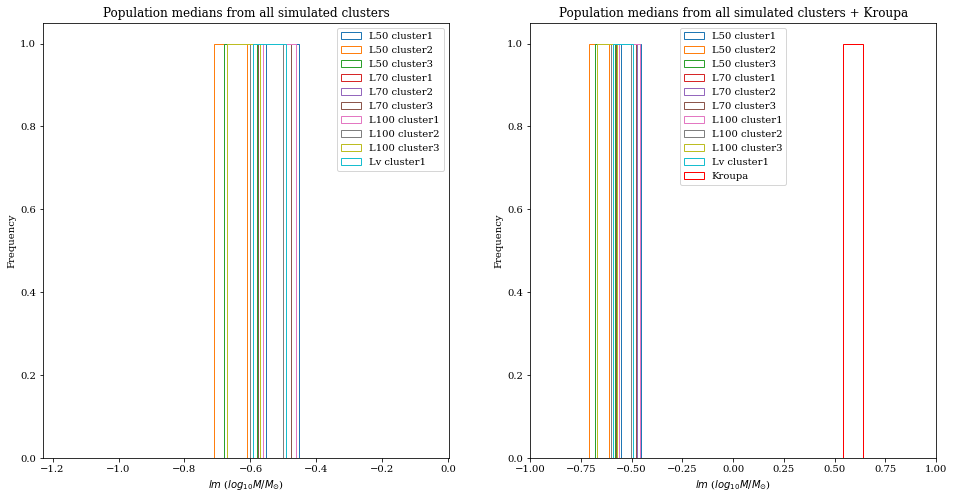

In [36]:
# do all cluster distributions have the same distribution?

samples = [L50_cluster1['Mass'], L50_cluster2['Mass'], L50_cluster3['Mass'], L70_cluster1['Mass'], L70_cluster2['Mass'], L70_cluster3['Mass'], L100_cluster1['Mass'], L100_cluster2['Mass'], L100_cluster3['Mass'], Lv_all['Mass']]
stat, critical_vals, p = stats.anderson_ksamp(samples)
# null is that they are drawn from same population without having 
# to specify distribution function of that population

print("Anderson-Darling test for k-samples:\nstat = %.3f" % stat)
print("critical vals (25%, 10%, 5%, 2.5%, 1%, 0.5%, 0.1%) =", [np.round(x, decimals=2) for x in critical_vals])
print("p-value = %.3f" % p)
if stat > max(critical_vals):
    print("Test value < all critical values so they all have same distribution (as expected) and we can't reject the null hypothesis\n")

stat, p = stats.kruskal(L50_cluster1['Mass'], L50_cluster2['Mass'], L50_cluster3['Mass'], L70_cluster1['Mass'], L70_cluster2['Mass'], L70_cluster3['Mass'], L100_cluster1['Mass'], L100_cluster2['Mass'], L100_cluster3['Mass'], Lv_all['Mass'])
# null is that population medians are equals
print("\nKrusal-Wallis test for independent k-samples:\nstat = %.3f, p value = %.3f" % (stat, p))
if p > 0.05:
    print("Population medians of all clusters are equal")
    
# null is that samples come from populations with equal variances 
stat, p = stats.levene(L50_cluster1['Mass'], L50_cluster2['Mass'], L50_cluster3['Mass'], L70_cluster1['Mass'], L70_cluster2['Mass'], L70_cluster3['Mass'], L100_cluster1['Mass'], L100_cluster2['Mass'], L100_cluster3['Mass'], Lv_all['Mass'])
print("\nLevene test for medians: stat = %.3f, p value = %.3f" % (stat,p))
if p > 0.05:
    print("Population medians of all clusters are equal")
        
print("\n*************************************************************")
print("\n\nnow adding k.bins from Kroupa and repeating tests...\n")
samples = [[np.log10(x) for x in k.bins], L50_cluster1['Mass'], L50_cluster2['Mass'], L50_cluster3['Mass'], L70_cluster1['Mass'], L70_cluster2['Mass'], L70_cluster3['Mass'], L100_cluster1['Mass'], L100_cluster2['Mass'], L100_cluster3['Mass'], Lv_all['Mass']]
stat, critical_vals, p = stats.anderson_ksamp(samples)
print("Anderson-Darling test for k-samples:\nstat = %.3f" % stat)
print("critical vals (25%, 10%, 5%, 2.5%, 1%, 0.5%, 0.1%) =", [np.round(x, decimals=2) for x in critical_vals])
print("p-value = %.3f" % p)
if stat > min(critical_vals):
    print("Test value > all critical values so at least one sample has a different distribution (as expected)")

stat, p = stats.kruskal([np.log10(x) for x in k.bins], L50_cluster1['Mass'], L50_cluster2['Mass'], L50_cluster3['Mass'], L70_cluster1['Mass'], L70_cluster2['Mass'], L70_cluster3['Mass'], L100_cluster1['Mass'], L100_cluster2['Mass'], L100_cluster3['Mass'], Lv_all['Mass'])
print("\nKrusal-Wallis test for independent k-samples:\nstat = %.3f, p value = %.3f" % (stat, p))
if p < 0.05:
    print("Population medians of all clusters are not equal")
    
stat, p = stats.levene([np.log10(x) for x in k.bins], L50_cluster1['Mass'], L50_cluster2['Mass'], L50_cluster3['Mass'], L70_cluster1['Mass'], L70_cluster2['Mass'], L70_cluster3['Mass'], L100_cluster1['Mass'], L100_cluster2['Mass'], L100_cluster3['Mass'], Lv_all['Mass'])
print("\nLevene test for medians: stat = %.3f, p value = %.3f" % (stat,p))
if p < 0.05:
    print("Population medians of all clusters are not equal")
# small p value for Levene means they do not have equal variances

fig, ax = plt.subplots(ncols=2, figsize=(16,8))
ax[0].set_title('Population medians from all simulated clusters')
ax[0].set_xlabel(r'$lm$ ($log_{10} M/M_{\odot}$)')
ax[0].set_ylabel('Frequency')
for x, name in zip(samples[1:], ['L50_cluster1', 'L50_cluster2', 'L50_cluster3', 'L70_cluster1', 'L70_cluster2', 'L70_cluster3', 'L100_cluster1', 'L100_cluster2', 'L100_cluster3', 'Lv_cluster1']):
    ax[0].hist(np.median(x), histtype='step', label=name.replace("_", " "))
    ax[1].hist(np.median(x), histtype='step', label=name.replace("_", " "))

ax[1].hist(np.median(samples[0]), histtype='step', color='red', label='Kroupa')
ax[1].set_xlim([-1, 1])
ax[1].set_title('Population medians from all simulated clusters + Kroupa')
ax[1].set_xlabel(r'$lm$ ($log_{10} M/M_{\odot}$)')
ax[1].set_ylabel('Frequency')
ax[0].legend()
ax[1].legend(loc='upper center')
plt.show()

# permutation test for KS test

In [ ]:
simulation_samplesize = 100
for name in ['L50', 'L70', 'L100', 'Lv']:
    d = df[df['Simulation'] == name]
    palette = sns.color_palette(palette_name, 3)
    
    for i, cluster_name in enumerate(np.unique(d['Cluster'])):
        print(cluster_name)
        c = d[d['Cluster'] == cluster_name]
        c = c[c['Mass'] <= 8]
        k = Kroupa(sum(c['Mass']), 8)
                               
        fig, ax = plt.subplots(ncols=2, figsize=(12,6), sharey=True)
        plt.subplots_adjust(wspace=0.05)
        ax[0].set_xlabel('Maximum Distance (D+)')
        ax[0].set_ylabel('Frequency')
        fig.suptitle('1000 Monte Carlo simulations of KS Test for %s' % cluster_name)
        ax[0].set_title('KS Test Statistic Distribution')
        ax[1].set_xlabel('p-value')
        ax[1].set_title('KS Test p-value')
        
        all_stats, all_p =[],[]
        for i in range(1000): # 1000 simulations
            # get 100 random samples from sim and Kroupa
            idxs = np.random.randint(0, high=len(c), size=simulation_samplesize)
            sample = np.array(c['Mass'])[idxs]   
            idxs = np.random.randint(0, high=len(k.bins), size=simulation_samplesize)
            kroupa_bins = k.bins[idxs]
            kroupa_counts = k.counts[idxs]
            
            # get cumulative distributions
            kroupa_cumsum = np.cumsum(kroupa_counts*kroupa_bins)
            kroupa_cumsum /= kroupa_cumsum[-1]
            cumsum = np.cumsum(np.sort(sample))
            cumsum /= cumsum[-1] 

            stat, p_plus = stats.kstest(cumsum, kroupa_cumsum, alternative='greater', N=100)
            all_stats.append(stat)
            all_p.append(p_plus)
        
        # get cumulative distributions
        kroupa_cumsum = np.cumsum(k.counts*k.bins)
        kroupa_cumsum /= kroupa_cumsum[-1]
        cumsum = np.cumsum(np.sort(c['Mass']))
        cumsum /= cumsum[-1] 
        stat, p_plus = stats.kstest(cumsum, kroupa_cumsum, alternative='greater', N=len(cumsum)-1)       
        print("Average stats from 1000 runs of one-sided KS test: D+ value = %.3f, p value = %.2E" % (np.average(all_stats), np.average(all_p)))
        print("Actual stats: D+ value = %.3f, p value = %.2E" % (stat, p_plus))
        
        unique_stat, frequency_stat = np.unique(all_stats, return_counts=True)  
        unique_p, frequency_p = np.unique(all_p, return_counts=True)
        
        d_99 = 1.63/np.sqrt(len(c['Mass']))
        d_95 = 1.36/np.sqrt(len(c['Mass']))
        
        ax[0].axvline(d_99, linestyle='--', color='green', label='99\% CL')
        ax[0].axvline(d_95, linestyle='--', color='purple', label='95\% CL')
        ax[0].plot(unique_stat, frequency_stat, color=palette[2])
        ax[0].axvline(np.average(unique_stat), color='black', label='average')
        ax[0].axvline(stat, color='red', label='actual')
        ax[0].hist(all_stats, alpha=0.2, bins=unique_stat, color=palette[2])
        ax[0].legend()
        
        ax[1].plot(unique_p, frequency_p, color=palette[2])
        ax[1].axvline(np.average(unique_p), color='black', label='average')
        ax[1].axvline(p_plus, color='red', label='actual')
        ax[1].hist(all_p, alpha=0.2, bins=unique_p, color=palette[2])
        ax[1].legend()
        
        plt.show()
        plt.savefig("%s Monte Carlo KS test.png" % cluster_name)

# testing whether simulations have same distributions overall (i.e. cluster independent comparison)

In [ ]:
# do all simulations have same distributions (cluster-independent)?

print("testing whether all simulations' distributions (cluster-independent) are the same ...\n")

samples = [L50['Mass'], L70['Mass'], L100['Mass'], Lv['Mass']]
stat, critical_vals, p = stats.anderson_ksamp(samples)
# null is that they are drawn from same population without having 
# to specify distribution function of that population

print("Anderson-Darling test for k-samples:\nstat = %.3f" % stat)
print("critical vals (25%, 10%, 5%, 2.5%, 1%, 0.5%, 0.1%) =", [np.round(x, decimals=2) for x in critical_vals])
print("p-value = %.3f" % p)
if stat > max(critical_vals):
    print("Test value < all critical values so they all have same distribution (as expected)")
    print("Can't reject null hypothesis\n")
sig_levels = ['25%', '10%', '5%', '2.5%', '1%', '0.5%', '0.1%']
for i, val in enumerate(critical_vals):
    if stat > val:
        print("Test value > %d at a significance level of %s" % (val, sig_levels[i]))
        if p > 0.05:
            print("However, p value > 0.05 so not a significant result at 95% confidence level \nDon't reject null - simulations have same distribution")
stat, p = stats.kruskal(L50['Mass'], L70['Mass'], L100['Mass'], Lv['Mass'])
print("\nKrusal-Wallis test for independent k-samples:\nstat = %.3f, p value = %.3f" % (stat, p))
if p > 0.01:
    print("Population medians of all simulations are equal at 99% confidence level")
    
# null is that samples come from populations with equal variances 
stat, p = stats.levene(L50['Mass'], L70['Mass'], L100['Mass'], Lv['Mass'])
print("\nLevene test for medians: stat = %.3f, p value = %.3f" % (stat,p))
if p > 0.01:
    print("Population medians of all simulations are equal at 99% confidence level")
        
print("\n*************************************************************")
print("\n\nnow adding k.bins from Kroupa and repeating tests...\n")
k = Kroupa(sum([10**x for x in L50['Mass']]))
samples = [[np.log10(x) for x in k.bins], L50['Mass'], L70['Mass'], L100['Mass'], Lv['Mass']]
stat, critical_vals, p = stats.anderson_ksamp(samples)
print("Anderson-Darling test for k-samples:\nstat = %.3f" % stat)
print("critical vals (25%, 10%, 5%, 2.5%, 1%, 0.5%, 0.1%) =", [np.round(x, decimals=2) for x in critical_vals])
print("p-value = %.3f" % p)
if stat > min(critical_vals):
    print("Test value > all critical values so at least one sample has a different distribution (as expected)")

stat, p = stats.kruskal([np.log10(x) for x in k.bins], L50['Mass'], L70['Mass'], L100['Mass'], Lv['Mass'])
print("\nKrusal-Wallis test for independent k-samples:\nstat = %.3f, p value = %.3f" % (stat, p))
if p < 0.01:
    print("Population medians of all distributions are not equal at 99% confidence level")
    
stat, p = stats.levene([np.log10(x) for x in k.bins],L50['Mass'], L70['Mass'], L100['Mass'], Lv['Mass'])
print("\nLevene test for medians: stat = %.3f, p value = %.3f" % (stat,p))
if p < 0.01:
    print("Population medians of all distributions are not equal at 99% confidence level")
# small p value for Levene means they do not have equal variances

fig, ax = plt.subplots(ncols=2, figsize=(16,8))
ax[0].set_title('Population medians from all simulations')
ax[0].set_xlabel(r'$lm$ ($log_{10} M/M_{\odot}$)')
ax[0].set_ylabel('Frequency')
for x, name in zip(samples[1:], ['L50', 'L70', 'L100', 'Lv']):
    ax[0].hist(np.median(x), histtype='step', label=name)
    ax[1].hist(np.median(x), histtype='step', label=name)

ax[1].hist(np.median(samples[0]), histtype='step', color='red', label='Kroupa')
ax[1].set_xlim([-0, 0.75])
ax[1].set_title('Population medians from all simulations + Kroupa')
ax[1].set_xlabel(r'$lm$ ($log_{10} M/M_{\odot}$)')
ax[1].set_ylabel('Frequency')
ax[0].legend()
ax[1].legend(loc='upper left')
plt.show()

# extra statistics for simulations_all stars 

In [ ]:

limits = [5,8] # number of solar masses for upper limit 

for limit in limits:
    print("\n####################################################\n\n Doing statistics for ALL stars less than %d solar masses" % limit)
    
    for i, (name, sim) in enumerate(zip(['L50', 'L70', 'L100', 'Lv'], [L50, L70, L100, Lv])):
        sim['Mass'] = 10**sim['Mass']
        d = sim[sim['Mass'] <= limit]
        unique, counts = np.unique(np.sort(d['Mass']), return_counts=True)
        k = Kroupa(sum([10**x for x in d['Mass']]), limit)
        
        print("\n*************************************************************\n\n           %s STATISTICS \n" % name )
        
        # get cumulative distributions
        kroupa_cumsum = np.cumsum(np.array(k.counts)*np.array(k.bins))
        kroupa_cumsum /= kroupa_cumsum[-1]
        cumsum = np.cumsum(np.sort(d['Mass']))
        cumsum /= cumsum[-1]
        
        ########################################################################

        # descriptive stats:
        unique, counts = np.unique(np.sort(d['Mass']), return_counts=True)
        prob = counts/sum(counts)
        print('Descriptive statistics in solar masses:')
        print("          Simulation mean = %.3f, median = %.3f, standard dev = %.3f" % (np.average(d['Mass']), np.median(d['Mass']), np.std(d['Mass'])))
        idx = np.argmax(prob)
        print("          Most frequent/probable stellar mass: %.3f\n" % unique[idx])
        print("          Kroupa mean = %.3f, median = %.3f, standard dev = %.3f" % (np.average(k.bins), np.median(k.bins), np.std(k.bins)))
        idx = np.argmax(np.array(k.counts)/sum(k.counts))
        print("          Kroupa most frequent/probable stellar mass: %.3f\n" % unique[idx])

        ########################################################################

        # CVM test : compares underlying distribution of array of observed Xi... Xf values to a theoretical CDF
        res = stats.cramervonmises(c['Mass'], k.cdf)
        print("\nCramer von Mises test:")
        print("          stat = %.3f, p value = %.3f" % (res.statistic, res.pvalue))
        if res.pvalue < 0.01:
            print("----------> Simulated distribution doesn't come from Kroupa at the 99% confidence level (p = 0.01)")
            print("----------> NOT A GOOD FIT")

        ########################################################################

        # Kruskal Wallis test for independent samples via median

        stat, p = stats.kruskal(c['Mass'], k.bins)
        print("\nKrusal-Wallis analysis of variance:")
        print("          H stat = %.3f, p value = %.4f" % (stat, p))
        if p < 0.01:
            print("----------> Population medians are not equal at the 99% confidence level (p = 0.01)")
            print("----------> NOT A GOOD FIT")

        ########################################################################

#       # Mann Whitney U test - compares underlying distribution of 2 arrays of observed Xi...Xf values (using bins)
        n, bins = np.histogram(c['Mass'], bins=np.logspace(0.08, 150, 10001))
        stat, p = stats.mannwhitneyu(bins, np.array(k.bins), alternative='greater')
        print("\nMann-Whitney U test of location difference:")
        print("          stat = %.3f, p value = %.3f" % (stat, p))
        if p < 0.01:
            print("----------> Simulated CDF > Kroupa CDF at the 99% confidence level (p = 0.01)")
            print("----------> NOT A GOOD FIT")

        ########################################################################

         # Anderson Darling k-samples test (weights tails more than KS test but is better for small samples)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            warnings.warn("UserWarning arose", UserWarning)
            n, bins = np.histogram(np.sort(c['Mass']), bins=np.logspace(0.08, 150, 10001))
            stat, critical_vals, alpha = stats.anderson_ksamp([n, k.bins])
            print("\nAnderson-Darling test for k-samples:")
            print("          stat = %.3f" % stat)
            print("          critical vals (25%, 10%, 5%, 2.5%, 1%, 0.5%, 0.1%) =", critical_vals)
            print("          level of significance that we can reject the null hypothesis at = %.3f" % alpha)
        if stat > min(critical_vals):
            print("----------> Test value > all critical values so distributions are different")
            print("----------> NOT A GOOD FIT")

        ########################################################################

        # spearman correlation coefficient (non parametric)
        # equals 0 if there's no correlation, +/- 1 implies exact monotonic relationship
        stat, p = stats.spearmanr(n, k.bins)
        print("\nSpearman correlation coefficient:")
        print("          stat = %.3f, p value = %.3f\n" % (stat, p))
        if np.isclose(stat, 0, atol=0.3):
            print("----------> Simulated and Kroupa distribution have little (if any) correlation")
            print("----------> NOT A GOOD FIT")

        ########################################################################

#       Levene test - null hypothesis: samples are from populations w/ equal variances

        # median test is recommended for skewed (non normal) distributions

        stat, p = stats.levene(n, k.bins)
        print("Levene test for medians:")
        print("          stat = %.3f, p value = %.3f" % (stat,p))
        if p < 0.01:
            print("----------> Population medians are not equal at the 99% confidence level (p = 0.01)")
            print("----------> NOT A GOOD FIT")

        ########################################################################

# ignore below this, was playing around with animated plots to check if CDF was being calculated correctly since CDF = area under the PDF curve 

In [11]:
# histogram our data with numpy
%matplotlib nbagg
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
bins = np.arange(0.08,8,0.01)

# initialize empty 
line_unweighted, = ax1.plot([0], [0], color='k', lw=2)
line_weighted, = ax1.plot([0], [0], color='b', lw=2)
masses = np.array(L50_cluster1['Mass'])
masses = masses[masses <= 8]
n, bins = np.histogram(masses, density=True, bins=bins)
_, _, bar_container = ax2.hist([0], [0], lw=1, alpha=0.5, cumulative=True)
ax2.clear()


bin_centers = [np.average(bins[i:i+1]) for i,idx in enumerate(bins[:-1])]
cumsum = np.cumsum(bin_centers)
cumsum /= cumsum[-1]
cumsum_weighted = np.cumsum(bin_centers*n)
cumsum_weighted /= cumsum_weighted[-1]

k = Kroupa(sum(masses), 8)
kroupa_cs = np.cumsum(k.bins*k.counts)
kroupa_cs /= kroupa_cs[-1]

line = [line_unweighted, line_weighted, bar_container]
def animate(i):
    #print("frame num=", i, "cumsum=", cumsum[:i], "counts:", n[:i])
#     line_unweighted.set_data(bin_centers[:i], cumsum[:i])
#     line_weighted.set_data(bin_centers[:i], cumsum_weighted[:i])
    ax1.plot(bin_centers[:i], cumsum[:i], color='red')
    ax1.plot(bin_centers[:i], cumsum_weighted[:i], color='black')
    ax1.plot(k.bins[:i], kroupa_cs[:i], linestyle='--', color='purple')
    ax2.bar([np.log10(x) for x in bin_centers[:i]], n[:i], color='blue', alpha=0.5)
    return [line_unweighted, line_weighted]
    
anim = animation.FuncAnimation(fig, animate, interval=10, frames=len(bin_centers), blit=True)
# anim.save('503.gif')
plt.show()


<IPython.core.display.Javascript object>



in normalize kroupa: bins are [8.0000e-02 9.0000e-02 1.0000e-01 ... 1.4997e+02 1.4998e+02 1.4999e+02] 



<IPython.core.display.Javascript object>


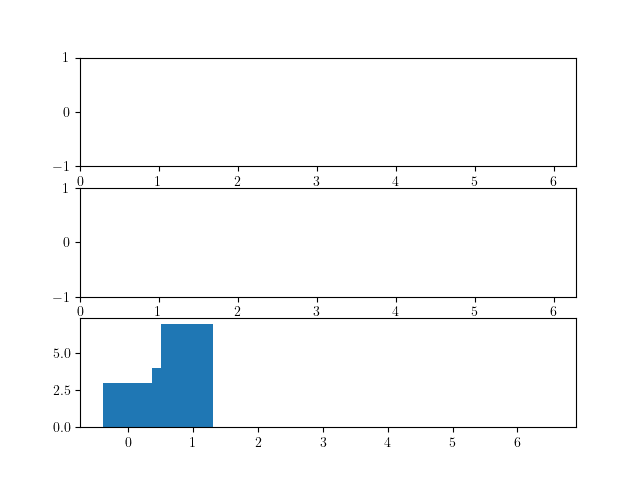

In [17]:
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib nbagg
t = np.linspace(0,2*np.pi)
x = np.sin(t)
x2 = np.cos(t)

fig, ax = plt.subplots(nrows=3)
ax[0].axis([0,2*np.pi,-1,1])
ax[1].axis([0,2*np.pi,-1,1])
l, = ax[0].plot([],[])
l2, = ax[1].plot([], [])
barcontainer, = ax[2].bar([0], [0])
n, bins = np.histogram(x, bins=t)
ax[2].clear()

def animate(i):
    l.set_data(t[:i], x[:i])
    l2.set_data(t[:i], x2[:i])
    ax[2].bar(t[:i], n[:i])
    return [l, l] #, barcontainer]

ani = animation.FuncAnimation(fig, animate, frames=len(t))
plt.show()